In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.float_format = '{:.6f}'.format
from sklearn.model_selection import cross_val_score,train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,auc,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Train data

In [90]:
train=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\train.csv")
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [91]:
# Duplicate rows
train[train.iloc[:,1:].duplicated()==True]

,id,campaign_id,coupon_id,customer_id,redemption_status
24627,40421,13,450,15,1
42928,70413,8,6,1210,1
43301,70999,13,468,1549,1
48626,79727,13,20,1574,1
49749,81601,8,906,1115,1
51937,85240,13,754,1250,1
59747,98171,29,443,659,1
64294,105566,10,689,389,1
64544,105957,13,726,959,1
73994,121513,5,689,626,1


In [92]:
# Droping duplicate rows
train=train.drop(index=train[train.iloc[:,1:].duplicated()==True].index,axis=0).reset_index(drop=True)

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78357 entries, 0 to 78356
Data columns (total 5 columns):
id                   78357 non-null int64
campaign_id          78357 non-null int64
coupon_id            78357 non-null int64
customer_id          78357 non-null int64
redemption_status    78357 non-null int64
dtypes: int64(5)
memory usage: 3.0 MB


In [94]:
train.shape

(78357, 5)

In [95]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [96]:
train.nunique()

id                   78357
campaign_id             18
coupon_id              866
customer_id           1428
redemption_status        2
dtype: int64

#### Train_data features

 1. Campaign

In [97]:
# Unique campaign
sorted(train.campaign_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30]

In [98]:
#Total unique campaign
train.campaign_id.nunique()

18

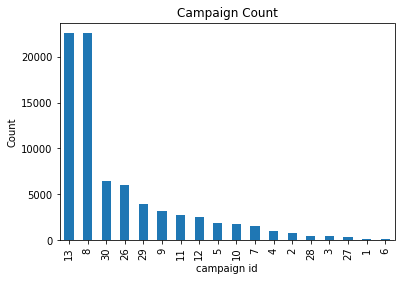

In [99]:
train.campaign_id.value_counts().plot(kind="bar")
plt.title("Campaign Count")
plt.xlabel("campaign id")
plt.ylabel("Count")
plt.show()

In [100]:
# Campaign count in train data

2. coupon_id

In [101]:
# Total unique coupon id
train.coupon_id.nunique()

866

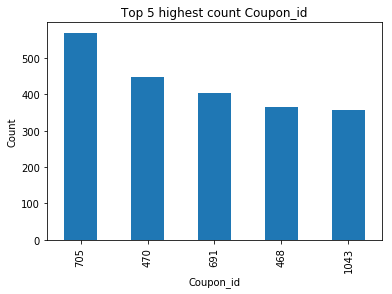

In [102]:
# Coupon_id 705 has the highest count in the train data (Top 5)
train.coupon_id.value_counts().head().plot.bar()
plt.title("Top 5 highest count Coupon_id")
plt.xlabel("Coupon_id")
plt.ylabel("Count")
plt.show()

3. customer_id 

In [103]:
# Total unique customers
train.customer_id.nunique()

1428

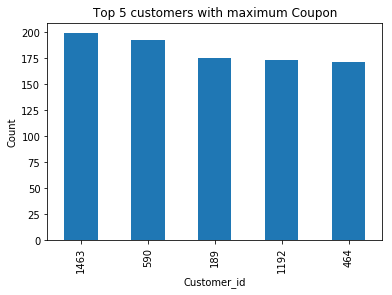

In [104]:
# Top 5 customers with maximum coupons (Top 5)
train.customer_id.value_counts().head().plot.bar()
plt.title("Top 5 customers with maximum Coupon")
plt.xlabel("Customer_id")
plt.ylabel("Count")
plt.show()

4. redemption_status 

In [105]:
train.redemption_status.value_counts()

0    77640
1      717
Name: redemption_status, dtype: int64

In [106]:
(train.redemption_status.value_counts()/train.shape[0])*100

0   99.084957
1    0.915043
Name: redemption_status, dtype: float64

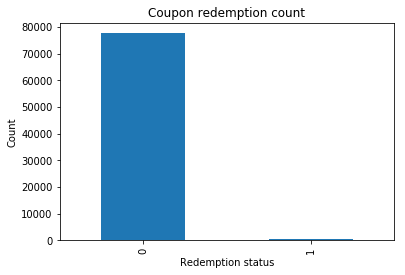

In [107]:
train.redemption_status.value_counts().plot(kind='bar')
plt.title("Coupon redemption count")
plt.ylabel("Count")
plt.xlabel("Redemption status")
plt.show()

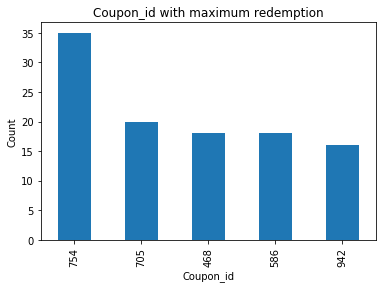

In [108]:
# Coupon_id with maximum redemption (Top 5)
train[train.redemption_status==1]["coupon_id"].value_counts().head().plot.bar()
plt.title("Coupon_id with maximum redemption")
plt.ylabel("Count")
plt.xlabel("Coupon_id")
plt.show()

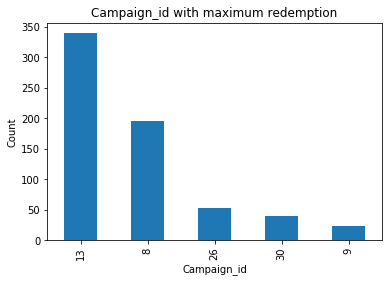

In [109]:
# Campaign_id with maximum redemption (Top 5)
train[train.redemption_status==1]["campaign_id"].value_counts().head().plot.bar()
plt.title("Campaign_id with maximum redemption")
plt.ylabel("Count")
plt.xlabel("Campaign_id")
plt.show()
# campaign_id 13 is most successful campaign with 346 coupon redemption

In [110]:
# All campaign are having some coupon redemtion
train[train.redemption_status==1]["campaign_id"].value_counts().count()

18

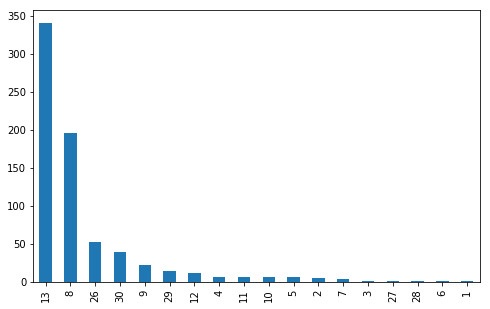

In [111]:
plt.figure(figsize=(8,5))
train[train.redemption_status==1]["campaign_id"].value_counts().plot(kind="bar")
plt.show()

In [112]:
# Customer with maximum redemption (Top 5)

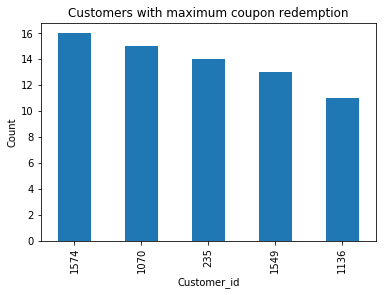

In [113]:
train[train.redemption_status==1]["customer_id"].value_counts().head().plot.bar()
plt.title("Customers with maximum coupon redemption")
plt.ylabel("Count")
plt.xlabel("Customer_id")
plt.show()

In [114]:
# Total unique customers who redeemed coupon
train[train.redemption_status==1]["customer_id"].value_counts().count()

247

# Campaign data

In [115]:
campaign=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\campaign_data.csv")
campaign

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13
5,22,X,16/09/13,18/10/13
6,18,X,10/08/13,04/10/13
7,19,Y,26/08/13,27/09/13
8,17,Y,29/07/13,30/08/13
9,16,Y,15/07/13,16/08/13


In [116]:
campaign.duplicated().sum()

0

In [117]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null object
end_date         28 non-null object
dtypes: int64(1), object(3)
memory usage: 976.0+ bytes


In [118]:
# Converting start_date & end_date columns to datetime datatype
campaign.start_date=pd.to_datetime(campaign.start_date)
campaign.end_date=pd.to_datetime(campaign.end_date)


In [119]:
campaign.end_date - campaign.start_date

0      60 days
1      32 days
2     130 days
3      97 days
4      32 days
5      32 days
6    -181 days
7      32 days
8      32 days
9      32 days
10    -12 days
11     75 days
12     32 days
13     62 days
14     31 days
15     77 days
16    182 days
17    -25 days
18     56 days
19   -289 days
20     32 days
21     37 days
22     32 days
23    133 days
24    112 days
25     61 days
26     63 days
27    -78 days
dtype: timedelta64[ns]

In [120]:
### We can observe there is negative period in campaign_period and trying to rectify it using 3 methods 

In [121]:
campaign.dtypes

campaign_id               int64
campaign_type            object
start_date       datetime64[ns]
end_date         datetime64[ns]
dtype: object

In [122]:
# Adding new Feature 
campaign["campaign_period"]=(campaign.end_date-campaign.start_date).dt.days
campaign["campaign_Year"]=campaign.start_date.dt.year
campaign["campaign_month"]=campaign.start_date.dt.month

In [123]:
def quarter(month,year):
    if (month in [1,2,3]) and (year == 2012):
        return 1
    elif (month in [4,5,6]) and (year == 2012):
        return 2
    elif (month in [7,8,9]) and (year == 2012):
        return 3
    elif (month in [10,11,12]) and (year == 2012):
        return 4
    elif (month in [1,2,3]) and (year == 2013):
        return 5
    elif (month in [4,5,6]) and (year == 2013):
        return 6
    elif (month in [7,8,9]) and (year == 2013):
        return 7
    elif (month in [10,11,12]) and (year == 2013):
        return 8

In [124]:
# Adding campaign_quarter feature
campaign["campaign_quarter"]=list(map(lambda x,y: quarter(x,y),campaign.campaign_month,campaign.campaign_Year))

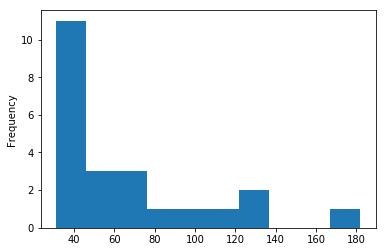

In [125]:
campaign[campaign["campaign_period"]>0]["campaign_period"].plot.hist()
plt.show()

In [126]:
campaign[campaign["campaign_period"]>0]["campaign_period"].median()

56.0

In [127]:
campaign[campaign["campaign_period"]>0]["campaign_period"].mean()

63.65217391304348

In [128]:
# Method -2 - Replacing negative period with median since data is skewed

campaign["campaign_period"]=campaign["campaign_period"].apply(lambda x :56 if x<0 else x )

In [129]:
campaign

,campaign_id,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
0,24,Y,2013-10-21,2013-12-20,60,2013,10,8
1,25,Y,2013-10-21,2013-11-22,32,2013,10,8
2,20,Y,2013-07-09,2013-11-16,130,2013,7,7
3,23,Y,2013-08-10,2013-11-15,97,2013,8,7
4,21,Y,2013-09-16,2013-10-18,32,2013,9,7
5,22,X,2013-09-16,2013-10-18,32,2013,9,7
6,18,X,2013-10-08,2013-04-10,56,2013,10,8
7,19,Y,2013-08-26,2013-09-27,32,2013,8,7
8,17,Y,2013-07-29,2013-08-30,32,2013,7,7
9,16,Y,2013-07-15,2013-08-16,32,2013,7,7


In [130]:
# Converting columns to object datatype
campaign["campaign_Year"]=campaign["campaign_Year"].astype("object")
campaign["campaign_month"]=campaign["campaign_month"].astype("object")

In [131]:
#campaign.drop(["start_date","end_date"],axis=1,inplace=True)

In [132]:
campaign.dtypes

campaign_id                  int64
campaign_type               object
start_date          datetime64[ns]
end_date            datetime64[ns]
campaign_period              int64
campaign_Year               object
campaign_month              object
campaign_quarter             int64
dtype: object

In [133]:
campaign.isnull().sum()

campaign_id         0
campaign_type       0
start_date          0
end_date            0
campaign_period     0
campaign_Year       0
campaign_month      0
campaign_quarter    0
dtype: int64

In [134]:
campaign.shape

(28, 8)

#### Campaign features

1. Campaign_id

In [135]:
# Number of campaign - 28
campaign.campaign_id.count()

28

In [136]:
A=set(train.campaign_id)
B=set(campaign.campaign_id)

In [137]:
A # Campaign available in train data

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30}

In [138]:
# Campaign_id not available in train data
D=list(B-A)
D

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

2. Campaign_type

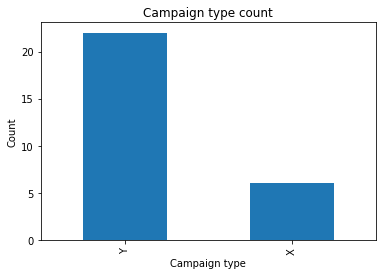

In [139]:
# Types of campaign
campaign.campaign_type.value_counts().plot(kind="bar")
plt.title("Campaign type count")
plt.ylabel("Count")
plt.xlabel("Campaign type")
plt.show()

3. Campaign_period

In [140]:
campaign.campaign_period.nunique()

15

In [141]:
campaign.campaign_period.unique()

array([ 60,  32, 130,  97,  56,  75,  62,  31,  77, 182,  37, 133, 112,
        61,  63], dtype=int64)

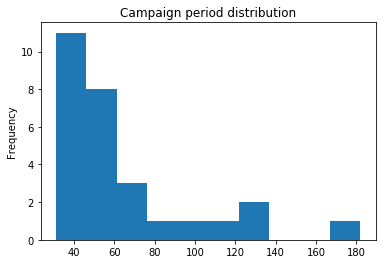

In [142]:
campaign[campaign.campaign_period>0]["campaign_period"].plot.hist()
plt.title("Campaign period distribution")
plt.show()

In [143]:
campaign[campaign.campaign_period>0]["campaign_period"].mean()

62.285714285714285

In [144]:
campaign[campaign.campaign_period>0]["campaign_period"].median()

56.0

In [145]:
# Campaign details related to train data (sorted wrt start_date)
campaign[(campaign.campaign_id.isin(A))].sort_values("start_date")

,campaign_id,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
24,29,Y,2012-08-10,2012-11-30,112,2012,8,3
26,27,Y,2012-08-25,2012-10-27,63,2012,8,3
25,28,Y,2012-09-16,2012-11-16,61,2012,9,3
23,30,X,2012-11-19,2013-04-01,133,2012,11,4
27,26,X,2012-12-08,2012-09-21,56,2012,12,4
21,1,Y,2012-12-12,2013-01-18,37,2012,12,4
22,2,Y,2012-12-17,2013-01-18,32,2012,12,4
18,3,Y,2012-12-22,2013-02-16,56,2012,12,4
17,6,Y,2013-01-28,2013-01-03,56,2013,1,5
16,7,Y,2013-02-02,2013-08-03,182,2013,2,5


In [146]:
# We can observe that campaign period are overlapping, For example -In sept 2012, three camapigns are running simultaneously

4. Campaign_year

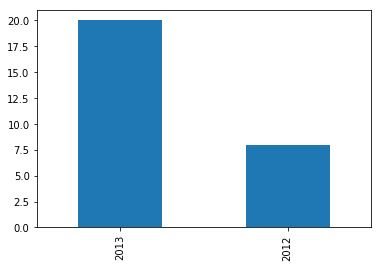

In [147]:
# No. of campaign per year
campaign.campaign_Year.value_counts().plot(kind="bar")
plt.show()

5. Campaign_month

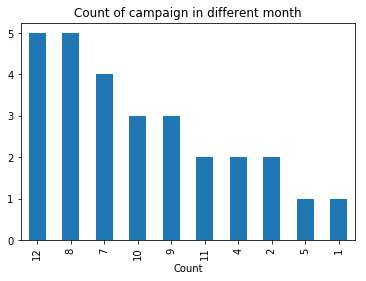

In [148]:
# No. of campaign in different months
campaign.campaign_month.value_counts().plot(kind="bar")
plt.title("Count of campaign in different month")
plt.xlabel("Month")
plt.xlabel("Count")
plt.show()

6. campaign_quarter

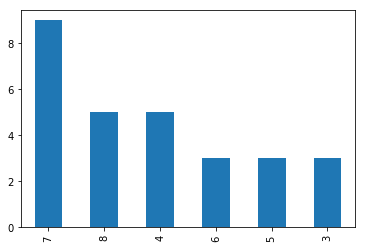

In [149]:
# Campaign in different quarters
campaign.campaign_quarter.value_counts().plot(kind="bar")
plt.show()

# Coupon_item_mapping data

In [150]:
coupon_item_mapping=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\coupon_item_mapping.csv")
coupon_item_mapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [151]:
coupon_item_mapping.duplicated().sum()

0

In [152]:
coupon_item_mapping.shape

(92663, 2)

In [153]:
coupon_item_mapping.isnull().sum()

coupon_id    0
item_id      0
dtype: int64

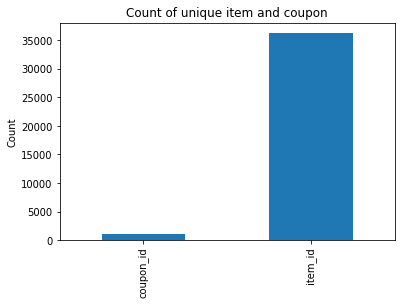

In [154]:
# No. of unique coupon_id and items
coupon_item_mapping.nunique().plot.bar()
plt.title("Count of unique item and coupon")
plt.ylabel("Count")
plt.show()

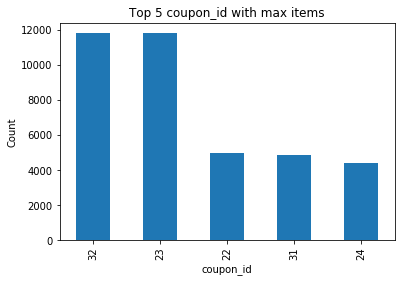

In [155]:
# Top 5 coupon_id with max items
coupon_item_mapping.groupby("coupon_id").item_id.agg("count").sort_values(ascending=False).head().plot.bar()
plt.title("Top 5 coupon_id with max items")
plt.ylabel("Count")
plt.show()

In [156]:
#checking each coupon have unique item or not
l1=list(coupon_item_mapping[coupon_item_mapping.coupon_id==32]["item_id"].unique())
l3=[]
for i in train.coupon_id.unique():
    l2=list(coupon_item_mapping[coupon_item_mapping.coupon_id==i]["item_id"].unique())
    c=0
    for  j in l2:
        if j in l1:
            c=c+1
    if c>0:
        l3.append(i)
print("Coupon_id which have same items as id no. 32",l3)


Coupon_id which have same items as id no. 32 [635, 517, 893, 689, 268, 278, 911, 663, 1114, 271, 256, 828, 24, 839, 658, 473, 627, 667, 1056, 279, 687, 275, 544, 490, 836, 996, 1044, 694, 968, 283, 734, 1057, 1018, 257, 641, 1045, 265, 912, 682, 733, 951, 293, 281, 280, 285, 284, 504, 986, 296, 26, 737, 954, 261, 740, 260, 249, 732, 852, 934, 937, 422, 1000, 502, 588, 979, 513, 23, 457, 25, 1108, 964, 1102, 292, 248, 579, 731, 516, 1099, 287, 474, 392, 276, 389, 455, 741, 735, 269, 1098, 273, 634, 691, 431, 666, 850, 738, 321, 244, 1105, 277, 1019, 692, 660, 967, 851, 15, 472, 662, 1090, 243, 406, 253, 471, 250, 550, 862, 998, 987, 5, 1092, 399, 391, 830, 829, 1101, 827, 665, 395, 1089, 400, 398, 626, 729, 739, 1082, 1093, 421, 838, 859, 965, 858, 963, 401, 282, 402, 831, 1095, 394, 1091, 263, 1088, 1097, 835, 291, 1096, 832, 393, 826, 264, 397, 837, 728]


In [157]:
# We can observe that the above coupon_id's have similar item as coupon_id-32 
# Each coupon doesn't have unique item 

In [158]:
x=set(coupon_item_mapping[coupon_item_mapping.coupon_id==635]["item_id"].unique())
y =set(coupon_item_mapping[coupon_item_mapping.coupon_id==32]["item_id"].unique())

inter=x.intersection(y)

# inter have items which is common between 32 and 635 coupon_id

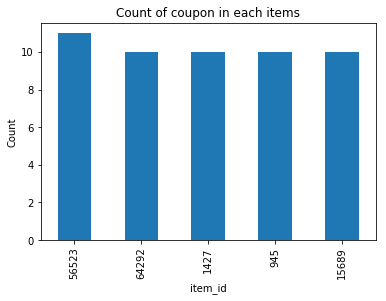

In [159]:
# Each item have one or more than one coupon_id
coupon_item_mapping.groupby("item_id")["coupon_id"].count().sort_values(ascending=False).head().plot.bar()
plt.title("Count of coupon in each items")
plt.xlabel("item_id")
plt.ylabel("Count")
plt.show()

In [160]:
# We can observe that each coupon_id doesn't have unique items

# customer_demographics data

In [161]:
customer_demographics=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\customer_demographics.csv")
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [162]:
customer_demographics.duplicated().sum()

0

In [163]:
customer_demographics.shape

(760, 7)

In [164]:
customer_demographics.nunique()

customer_id       760
age_range           6
marital_status      2
rented              2
family_size         5
no_of_children      3
income_bracket     12
dtype: int64

In [165]:
customer_demographics.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

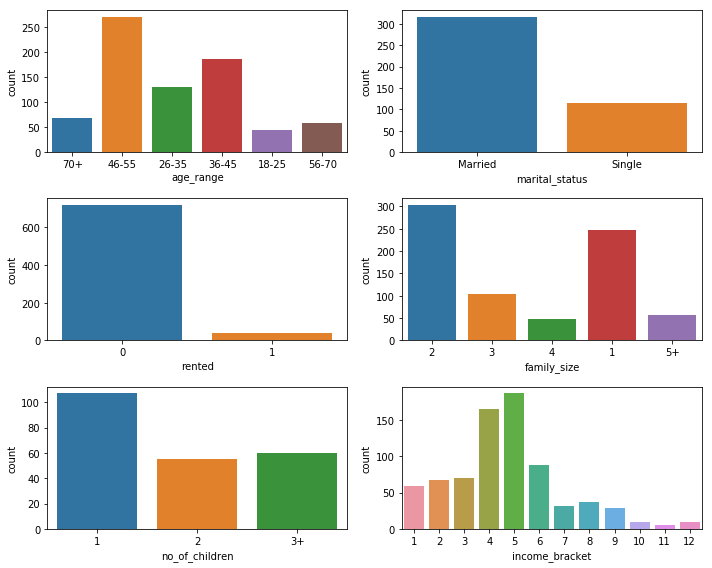

In [166]:
f,ax=plt.subplots(3,2,figsize=(10,8))
ax=ax.flatten()
ax_i=0
for i in customer_demographics.columns[1:]:
    sns.countplot(x=i,data=customer_demographics,ax=ax[ax_i])
    ax_i = ax_i+1

plt.tight_layout()
plt.show()




In [167]:
for i in customer_demographics.columns[1:]:
    print(i)
    print(customer_demographics[i].value_counts())
    print()
    
    

age_range
46-55    271
36-45    187
26-35    130
70+       68
56-70     59
18-25     45
Name: age_range, dtype: int64

marital_status
Married    317
Single     114
Name: marital_status, dtype: int64

rented
0    719
1     41
Name: rented, dtype: int64

family_size
2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

no_of_children
1     107
3+     60
2      55
Name: no_of_children, dtype: int64

income_bracket
5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: income_bracket, dtype: int64



In [168]:
train.customer_id.nunique()

1428

In [81]:
# There are total 1428 customers in train data but we only have dempgraphic details of 760 customers only.

# Item data

In [169]:
item=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\item_data.csv")
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [170]:
item.duplicated().sum()

0

In [171]:
item.shape

(74066, 4)

In [172]:
item.nunique()

item_id       74066
brand          5528
brand_type        2
category         19
dtype: int64

In [173]:
item.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
dtype: int64

#### Item Features

1. item_id

In [174]:
# There are total 74066 items
item.item_id.count()

74066

2. brand 

In [175]:
# There are total 5528 unique brand
item.brand.nunique()

5528

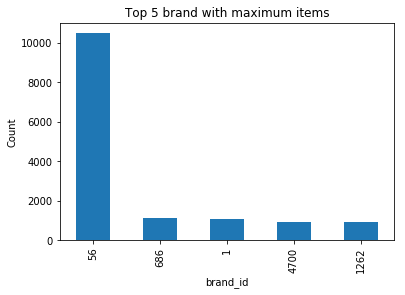

In [177]:
item.groupby("brand").item_id.agg("count").sort_values(ascending=False).head(5).plot.bar()
plt.title("Top 5 brand with maximum items")
plt.xlabel("brand_id")
plt.ylabel("Count")
plt.show()

3. brand_type

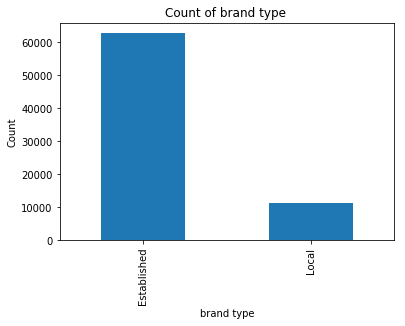

In [178]:
item.brand_type.value_counts().plot(kind="bar")
plt.title("Count of brand type ")
plt.xlabel("brand type")
plt.ylabel("Count")
plt.show()

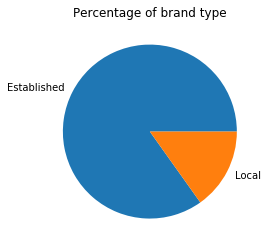

In [179]:
item.brand_type.value_counts().plot(kind="pie")
plt.title("Percentage of brand type")
plt.ylabel("")
plt.show()

4. Category

In [180]:
item.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

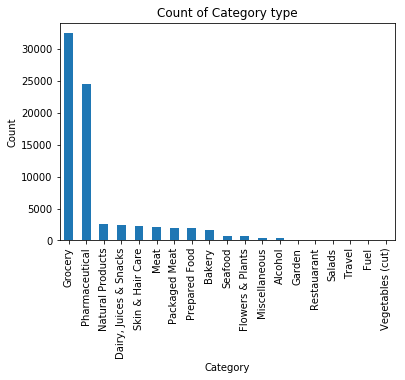

In [181]:
item.category.value_counts().plot(kind="bar")
plt.title("Count of Category type")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [182]:
# Clubbing differnt category 

In [183]:
fish_meat=["Meat","Packaged Meat","Seafood"]
dairy=["Dairy, Juices & Snacks","Prepared Food","Bakery","Salads","Vegetables (cut)"]
health=["Skin & Hair Care","Pharmaceutical","Natural Products"]
garden=["Flowers & Plants","Garden"]
misc=["Travel","Fuel","Restauarant","Alcohol"]

In [184]:
item["category"]=item["category"].apply(lambda x: "Meat & Fish" if x in fish_meat else x)
item["category"]=item["category"].apply(lambda x: "Food & Dairy" if x in dairy else x)
item["category"]=item["category"].apply(lambda x: "Health & Personal care" if x in health else x)
item["category"]=item["category"].apply(lambda x: "Garden" if x in garden else x)
item["category"]=item["category"].apply(lambda x: "Miscellaneous" if x in misc else x)

In [185]:
item["category"].value_counts()

Grocery                   32448
Health & Personal care    29248
Food & Dairy               6031
Meat & Fish                4774
Miscellaneous               799
Garden                      766
Name: category, dtype: int64

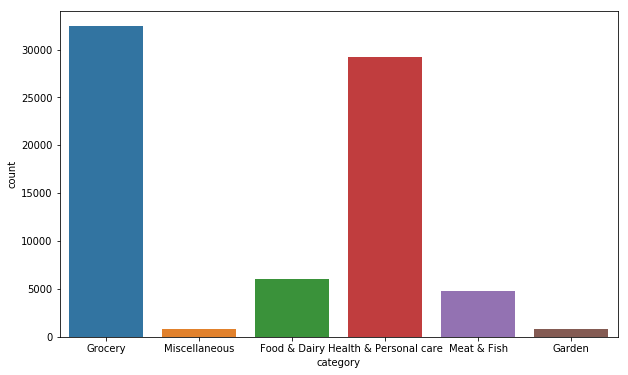

In [186]:
plt.figure(figsize=(10,6))
sns.countplot(item["category"])
plt.show()

# Customer Transaction data

In [187]:
cust_tran=pd.read_csv("I:\\DS Projects\\Capstone Project\\data\\customer_transaction_data.csv")
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000


In [188]:
cust_tran.duplicated().sum()

2916

In [189]:
cust_tran.drop_duplicates(inplace=True)

In [190]:
cust_tran.shape

(1321650, 7)

In [191]:
cust_tran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321650 entries, 0 to 1324565
Data columns (total 7 columns):
date               1321650 non-null object
customer_id        1321650 non-null int64
item_id            1321650 non-null int64
quantity           1321650 non-null int64
selling_price      1321650 non-null float64
other_discount     1321650 non-null float64
coupon_discount    1321650 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 80.7+ MB


In [192]:
cust_tran.describe()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1321650.000000,1321650.000000,1321650.000000,1321650.000000,1321650.000000,1321650.000000
mean,803.920299,29517.245814,130.888895,114.566592,-17.743481,-0.574810
std,457.272992,17907.279016,1312.458881,152.734569,37.821107,7.007641
min,1.000000,1.000000,1.000000,0.360000,-3120.310000,-1992.230000
25%,418.000000,14683.000000,1.000000,49.510000,-23.150000,0.000000
50%,801.000000,26594.000000,1.000000,78.010000,-1.780000,0.000000
75%,1197.000000,42407.000000,1.000000,124.310000,0.000000,0.000000
max,1582.000000,74066.000000,89638.000000,17809.640000,0.000000,0.000000


In [193]:
cust_tran.nunique()

date                 549
customer_id         1582
item_id            74063
quantity            9252
selling_price       4923
other_discount      1418
coupon_discount      232
dtype: int64

In [194]:
# Converting date column into datetime
cust_tran["date"]=pd.to_datetime(cust_tran["date"])

In [195]:
print("We have customer transaction data is between",min(cust_tran["date"]),"and",max(cust_tran["date"]))

We have customer transaction data is between 2012-01-02 00:00:00 and 2013-07-03 00:00:00


In [196]:
# Campaign start date
min(campaign.start_date)

Timestamp('2012-08-10 00:00:00')

We will only consider transaction data before minimum campaign start date because we need to predict whether particular customer redeem coupon or not for particular campaign

In [197]:
cust_tran0=cust_tran[cust_tran.date<min(campaign.start_date)]

In [198]:
cust_tran0.shape

(413119, 7)

In [199]:
cust_tran0.describe()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,413119.000000,413119.000000,413119.000000,413119.000000,413119.000000,413119.000000
mean,796.504261,27849.160767,121.868561,112.956330,-18.110303,-0.519165
std,458.063231,16236.311857,1263.448732,146.941678,36.488293,6.751908
min,1.000000,1.000000,1.000000,0.360000,-2671.500000,-1068.240000
25%,408.000000,14226.000000,1.000000,47.730000,-24.580000,0.000000
50%,785.000000,25574.000000,1.000000,78.010000,-3.210000,0.000000
75%,1192.000000,36465.000000,1.000000,124.310000,0.000000,0.000000
max,1582.000000,67595.000000,85055.000000,8014.140000,0.000000,0.000000


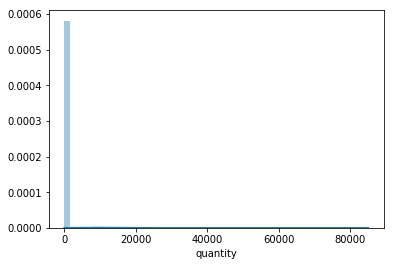

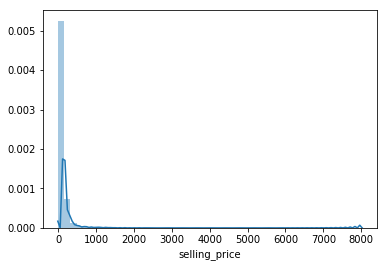

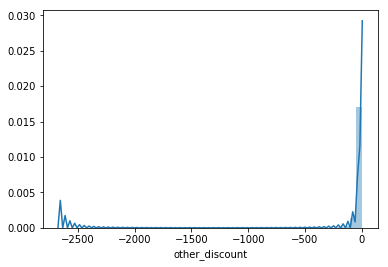

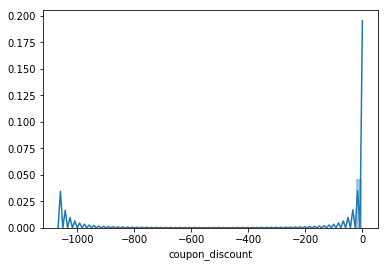

In [200]:
for  i in cust_tran0.columns[3:]:
    sns.distplot(cust_tran0[i])
    plt.show()

In [201]:
cust_tran0[cust_tran0.quantity>100].sort_values("quantity",ascending=False).head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
309578,2012-06-30,1521,49102,85055,7480.200000,-303.130000,0.000000
318896,2012-07-04,401,49009,61335,5350.480000,-218.350000,0.000000
107066,2012-04-13,103,49009,51912,3918.200000,-184.870000,0.000000
246506,2012-06-07,103,49009,41686,3562.000000,-148.540000,0.000000
100209,2012-04-09,883,49102,41485,3027.700000,-147.820000,0.000000


In [202]:
cust_tran0[cust_tran0.selling_price>1000].sort_values("selling_price",ascending=False).head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
80585,2012-03-29,512,58609,1,8014.140000,-2671.500000,0.000000
309578,2012-06-30,1521,49102,85055,7480.200000,-303.130000,0.000000
168236,2012-05-07,922,60982,6,7478.060000,0.000000,0.000000
23097,2012-02-14,1180,14280,3,7008.240000,0.000000,0.000000
96914,2012-04-07,246,45539,38,6270.190000,-78.010000,-89.050000


In [203]:
# Creating new feature discount percent
cust_tran["discount_percent"]=((np.abs(-cust_tran.other_discount-cust_tran.coupon_discount))/(cust_tran.selling_price+np.abs(-cust_tran.other_discount-cust_tran.coupon_discount)))*100

In [204]:
# Creating new feature item_coupon_covered
#cust_tran["item_coupon_covered"]= list(map(lambda x,y : 1 if (x<0 and y==1) else 0,cust_tran.coupon_discount,cust_tran.item_coupon))

In [205]:
# Merging transaction data with item data to create new feature
item1 = item[["item_id","category"]]
cust_tran=pd.merge(cust_tran,item1,on='item_id',how="left")
cust_tran=pd.get_dummies(data=cust_tran,columns=["category"])
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,discount_percent,category_Food & Dairy,category_Garden,category_Grocery,category_Health & Personal care,category_Meat & Fish,category_Miscellaneous
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000,23.264418,0,0,0,1,0,0
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000,20.632799,0,0,0,1,0,0
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000,11.801242,0,0,1,0,0,0
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000,0.000000,0,0,1,0,0,0
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000,28.315556,0,0,1,0,0,0


In [206]:
# Checking whether all customer_id of train data is present in transaction data or not
a=set(train.customer_id.unique())
b= set(cust_tran.customer_id.unique())

In [207]:
c=b-a

In [208]:
a-b
# All customer_id of train data is present in transaction data

set()

In [209]:
# We have transaction data of 154 other customers as well
len(c)

154

#### Transaction data feature

1. date 

In [210]:
min(cust_tran.date)

Timestamp('2012-01-02 00:00:00')

In [211]:
max(cust_tran.date)

Timestamp('2013-07-03 00:00:00')

In [212]:
# The transaction data is between '2012-01-02' to '2013-07-03'
# We can observe that we don't have transaction data for all campaign period (August 2012 - December 2013)

2. customer_id 

In [213]:
# Total unique customer in transaction data
cust_tran.customer_id.nunique()

1582

In [214]:
# Total unique customer in train data
train.customer_id.nunique()

1428

3. item_id

In [215]:
# Item count (top 5)
cust_tran.item_id.value_counts().sort_values(ascending=False).head()

49009    13536
34047     6177
13174     3865
45502     3280
29847     2272
Name: item_id, dtype: int64

In [216]:
# Total unique item in transaction data
cust_tran.item_id.nunique()

74063

4. quantity

In [217]:
cust_tran.quantity.unique()

array([    1,     3,     2, ..., 15853, 21837, 19364], dtype=int64)

In [218]:
cust_tran.quantity.nunique()

9252

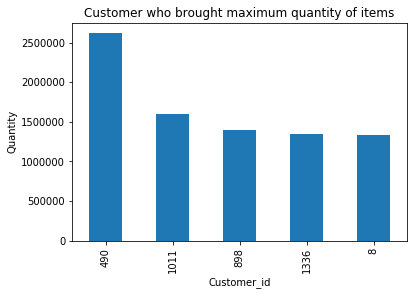

In [219]:
# Top 5 customers who brought maximum quantity of items
cust_tran.groupby("customer_id")["quantity"].sum().sort_values(ascending=False).head().plot.bar()
plt.title("Customer who brought maximum quantity of items")
plt.xlabel("Customer_id")
plt.ylabel("Quantity")
plt.show()

In [220]:
# Transaction details of customer_id - 490
cust_tran[cust_tran.customer_id==490].sort_values(by='quantity',ascending=False)

# We can observe that in many instances customer_id 490 have brought more than 20,000 quantity in single transaction 

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,discount_percent,category_Food & Dairy,category_Garden,category_Grocery,category_Health & Personal care,category_Meat & Fish,category_Miscellaneous
857039,2013-01-13,490,49009,24068,2228.030000,-0.360000,0.000000,0.016155,0,0,0,0,0,1
53227,2012-03-13,490,49009,23797,1745.380000,-0.360000,0.000000,0.020622,0,0,0,0,0,1
193427,2012-05-17,490,49009,23795,1948.410000,-0.360000,0.000000,0.018473,0,0,0,0,0,1
67519,2012-03-22,490,49009,23227,1786.340000,-0.360000,0.000000,0.020149,0,0,0,0,0,1
864101,2013-01-16,490,49009,23084,2137.200000,-0.360000,0.000000,0.016842,0,0,0,0,0,1
299786,2012-06-27,490,49009,22961,2117.610000,-0.360000,0.000000,0.016997,0,0,0,0,0,1
799764,2012-12-24,490,49009,22811,2030.340000,-0.360000,0.000000,0.017728,0,0,0,0,0,1
552955,2012-09-28,490,49009,22729,1861.140000,-0.360000,0.000000,0.019339,0,0,0,0,0,1
126405,2012-04-20,490,49009,22476,1832.650000,-0.360000,0.000000,0.019640,0,0,0,0,0,1
458916,2012-08-25,490,49009,22465,1727.570000,-0.360000,0.000000,0.020834,0,0,0,0,0,1


In [221]:
# Top 5 items with maximum quantity 
cust_tran.groupby("item_id")["quantity"].sum().sort_values(ascending=False).head()

item_id
49009    147128291
48973      9829518
49004      9321734
49102      1678839
39453      1021751
Name: quantity, dtype: int64

5. selling_price

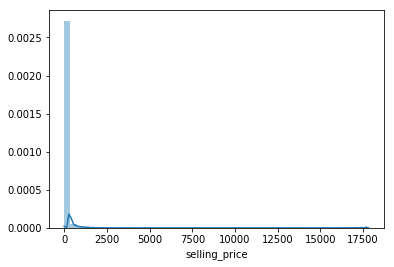

In [222]:
sns.distplot(cust_tran.selling_price)
plt.show()

In [223]:
# Maximum selling price
max(cust_tran.selling_price)

17809.64

In [224]:
# Minimum Selling price
min(cust_tran.selling_price)

0.36

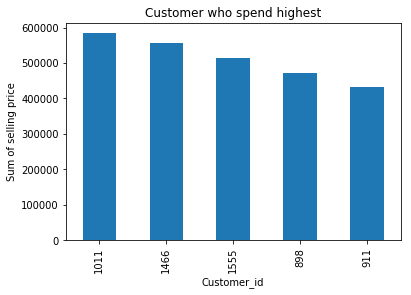

In [225]:
# Customer who spend highest in transaction data (not considering discount)
cust_tran.groupby("customer_id")["selling_price"].sum().sort_values(ascending=False).head().plot.bar()
plt.title("Customer who spend highest")
plt.xlabel("Customer_id")
plt.ylabel("Sum of selling price")
plt.show()

6. other_discount

In [226]:
# No. of transaction with other discount
cust_tran[cust_tran.other_discount<0]["customer_id"].count()

669996

In [227]:
# No. of Unique Customer's who got other_discount
cust_tran[cust_tran.other_discount<0]["customer_id"].nunique()

1582

7.coupon_discount

In [228]:
# No. of transaction with coupon discount
cust_tran[cust_tran.coupon_discount<0]["customer_id"].count()

20486

In [229]:
# No. of Unique Customer's who got coupon_discount
cust_tran[cust_tran.coupon_discount<0]["customer_id"].nunique()

1249

8.item_coupon

In [230]:
#cust_tran['item_coupon'].value_counts()

In [231]:
# Quantity brought by customer wrt date
cust_tran.groupby(["customer_id","date"])["quantity"].sum().head()

customer_id  date      
1            2012-02-21    31
             2012-03-08    13
             2012-03-29     9
             2012-04-04    28
             2012-04-11    17
Name: quantity, dtype: int64

In [232]:
cust_tran.groupby(["customer_id","date"])["quantity"].sum().shape

(142445,)

In [233]:
# Unique Item brought by customer wrt date
cust_tran.groupby(["customer_id","date"])["item_id"].nunique().head()

customer_id  date      
1            2012-02-21    27
             2012-03-08    10
             2012-03-29     8
             2012-04-04    19
             2012-04-11    14
Name: item_id, dtype: int64

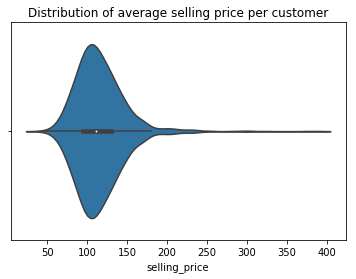

In [234]:
sns.violinplot(cust_tran.groupby("customer_id").selling_price.mean())
plt.title("Distribution of average selling price per customer")
plt.show()

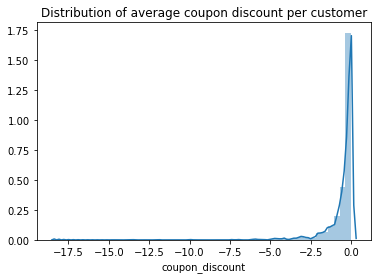

In [235]:
sns.distplot(cust_tran.groupby("customer_id").coupon_discount.mean())
plt.title("Distribution of average coupon discount per customer")
plt.show()

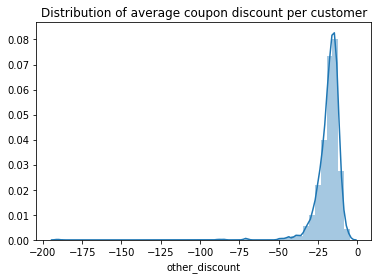

In [236]:
sns.distplot(cust_tran.groupby("customer_id").other_discount.mean())
plt.title("Distribution of average coupon discount per customer")
plt.show()

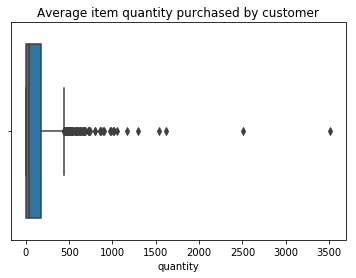

In [237]:
sns.boxplot(cust_tran.groupby("customer_id").quantity.mean())
plt.title("Average item quantity purchased by customer")
plt.show()

In [238]:
cust_tran.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'discount_percent',
       'category_Food & Dairy', 'category_Garden', 'category_Grocery',
       'category_Health & Personal care', 'category_Meat & Fish',
       'category_Miscellaneous'],
      dtype='object')

## Bivariate Analyisis

In [239]:
c1=cust_tran.groupby("customer_id")['quantity', 'selling_price','other_discount', 'coupon_discount', 'discount_percent'].mean().reset_index()
c1.columns=['customer_id', 'average_quantity', 'average_selling_price', 'average_other_discount',
       'average_coupon_discount', 'average_discount_percent']

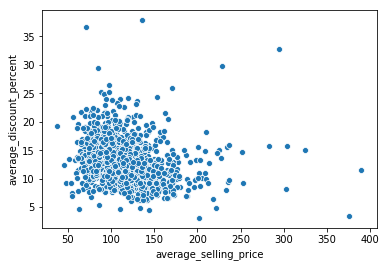

In [240]:
sns.scatterplot(c1['average_selling_price'],c1['average_discount_percent'])
plt.show()

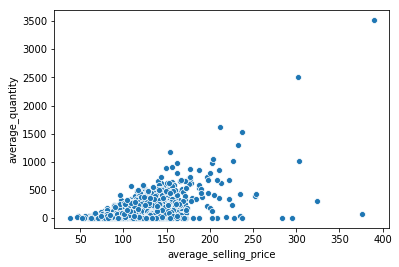

In [241]:
sns.scatterplot(c1['average_selling_price'],c1['average_quantity'])
plt.show()

In [242]:
c1=cust_tran.groupby("customer_id")['quantity', 'selling_price','other_discount', 'coupon_discount', 'discount_percent'].mean().reset_index()
c1=pd.merge(train,c1,how="left",on='customer_id')

c1=c1.drop(['customer_id',"coupon_id","id","campaign_id"],axis=1)
c1.columns=['redemption_status', 'average_quantity', 'average_selling_price', 'average_other_discount',
      'average_coupon_discount', 'average_discount_percent']
c1.head()

,redemption_status,average_quantity,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent
0,0,340.487097,184.260484,-33.168935,-0.287258,14.991237
1,0,31.619792,234.625130,-27.577422,-3.223411,15.511700
2,0,1.392157,121.007730,-17.769174,-2.168421,12.192731
3,0,1.291139,98.276034,-16.655570,-0.751477,13.661214
4,0,247.443060,120.636103,-20.524733,-0.471548,13.817609


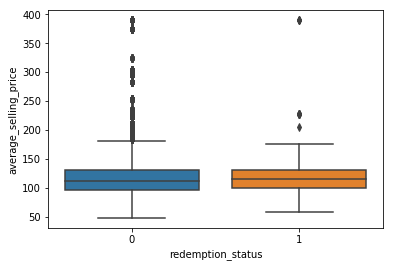

In [244]:
sns.boxplot(c1.redemption_status,c1['average_selling_price'])
plt.show()

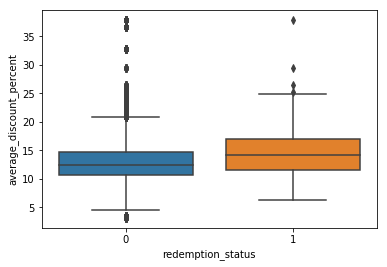

In [245]:
sns.boxplot(c1.redemption_status,c1.average_discount_percent)
plt.show()

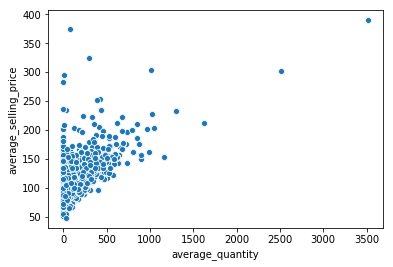

In [246]:
sns.scatterplot(c1.average_quantity,c1.average_selling_price)
plt.show()

In [247]:
t1=pd.merge(train,campaign,how="left",on='campaign_id')
t1.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,56,2013,5,6
1,2,13,116,48,0,X,2013-05-19,2013-05-07,56,2013,5,6
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,56,2013,5,6
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5


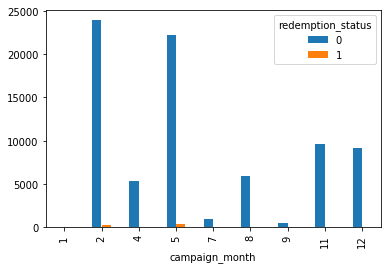

In [248]:
pd.crosstab(t1.campaign_month,t1.redemption_status).plot.bar()
plt.show()

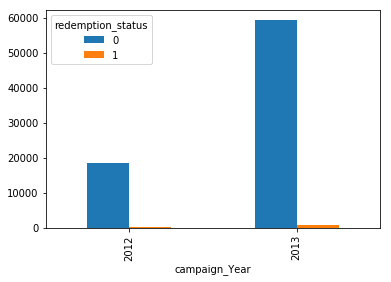

In [249]:
pd.crosstab(t1.campaign_Year,t1.redemption_status).plot.bar()
plt.show()

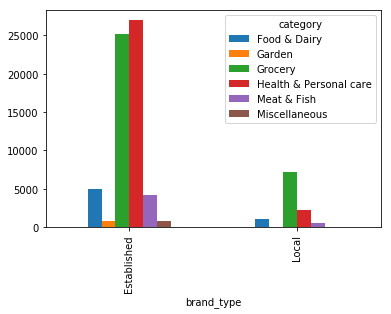

In [250]:
pd.crosstab(item.brand_type,item.category).plot.bar()
plt.show()

In [251]:
t2=pd.merge(cust_tran,item,how='left',on='item_id')
t2.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,discount_percent,category_Food & Dairy,category_Garden,category_Grocery,category_Health & Personal care,category_Meat & Fish,category_Miscellaneous,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000,23.264418,0,0,0,1,0,0,56,Local,Health & Personal care
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000,20.632799,0,0,0,1,0,0,56,Local,Health & Personal care
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000,11.801242,0,0,1,0,0,0,524,Established,Grocery
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000,0.000000,0,0,1,0,0,0,1134,Established,Grocery
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000,28.315556,0,0,1,0,0,0,524,Established,Grocery


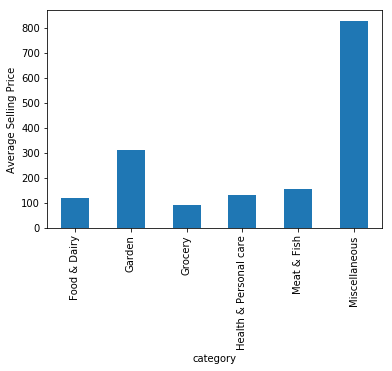

In [252]:
t2.groupby('category').selling_price.mean().plot.bar()
plt.ylabel("Average Selling Price")
plt.show()

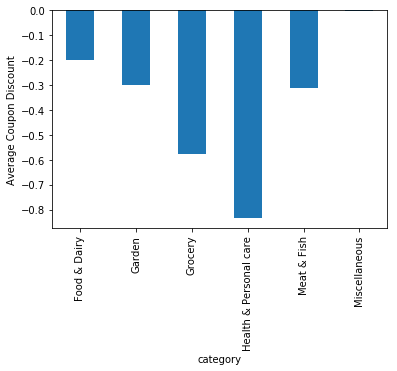

In [253]:
t2.groupby('category').coupon_discount.mean().plot.bar()
plt.ylabel("Average Coupon Discount")
plt.show()

## Multivariate Analysis

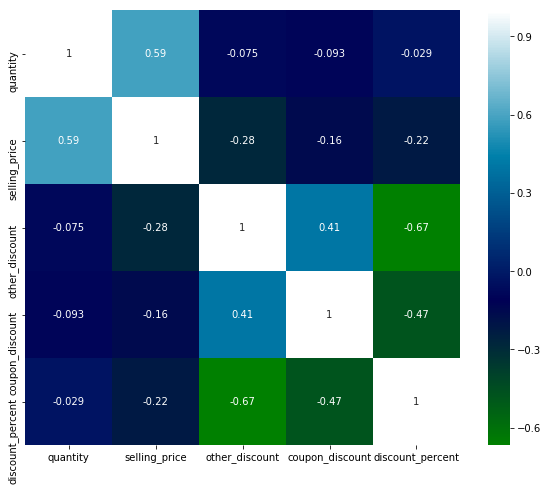

In [256]:
c1=cust_tran.groupby("customer_id")['quantity', 'selling_price','other_discount', 'coupon_discount', 'discount_percent'].mean().reset_index(drop=True)
plt.figure(figsize=(10,8))
sns.heatmap(c1.corr(),annot=True,square=True,cmap='ocean')
plt.show()

## Merging Data

In [257]:
# Merging train and campaign data
train_campaign=pd.merge(train,campaign,how='left',on='campaign_id')

In [258]:
train_campaign.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,56,2013,5,6
1,2,13,116,48,0,X,2013-05-19,2013-05-07,56,2013,5,6
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,56,2013,5,6
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5


In [259]:
# Adding new campaign feature unique customer and unique coupon
num_unique = lambda x:x.nunique()
campaign_feature=pd.merge(train,campaign,how="left",on='campaign_id')
campaign_feature=campaign_feature.groupby("campaign_id").agg({'customer_id':num_unique,'coupon_id':num_unique}).reset_index()
campaign_feature.columns=["campaign_id","campaign_customer_nunique","campaign_coupon_nunique"]
campaign_feature.head()

,campaign_id,campaign_customer_nunique,campaign_coupon_nunique
0,1,13,11
1,2,48,16
2,3,12,34
3,4,81,12
4,5,166,11


In [260]:
# Merging above 2 features with train_campaign table
train_campaign=pd.merge(train_campaign,campaign_feature,on='campaign_id',how='left')
train_campaign.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207
1,2,13,116,48,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8,176,18
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5,1076,208


In [261]:
# Merging item and coupon_mapping data
item_coupon_map=pd.merge(coupon_item_mapping,item,how="left",on="item_id")
item_coupon_map.head()


,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


In [262]:
# Creating dummies for brand_type and category columns of item_coupon_map table
item_coupon_map=pd.get_dummies(item_coupon_map,prefix="category_count",columns=["category","brand_type"])

item_coupon_map.head()

,coupon_id,item_id,brand,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local
0,105,37,56,0,0,1,0,0,0,0,1
1,107,75,56,0,0,1,0,0,0,0,1
2,494,76,209,0,0,1,0,0,0,1,0
3,522,77,278,0,0,1,0,0,0,1,0
4,518,77,278,0,0,1,0,0,0,1,0


In [263]:
# creating new features brand_nunique and item_count for each coupon in item_coupon_map table
coupon_feature=item_coupon_map[["coupon_id","brand","item_id"]].groupby("coupon_id")["brand","item_id"].nunique().reset_index()
coupon_feature.columns=["coupon_id",'coupon_unique_brand',"coupon_item_count"]
coupon_feature.head()

,coupon_id,coupon_unique_brand,coupon_item_count
0,1,3,39
1,2,1,2
2,3,2,17
3,4,1,24
4,5,1,7


In [264]:
# Grouping dummy columns in item_coupon_map 
# droping item_id and brand columns, since we have created 2 new feature using this columns
item_coupon_map=item_coupon_map.drop(["item_id","brand"],axis=1).groupby("coupon_id").agg("sum").reset_index()
item_coupon_map.head()

,coupon_id,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local
0,1,0.000000,0.000000,9.000000,30.000000,0.000000,0.000000,39.000000,0.000000
1,2,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000
2,3,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,17.000000,0.000000
3,4,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,24.000000,0.000000
4,5,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,7.000000,0.000000


In [265]:
# Merging 2 new features with item_coupon_map table
item_coupon_map=pd.merge(item_coupon_map,coupon_feature,how="inner",on="coupon_id")
item_coupon_map.head()

,coupon_id,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count
0,1,0.000000,0.000000,9.000000,30.000000,0.000000,0.000000,39.000000,0.000000,3,39
1,2,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1,2
2,3,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,17.000000,0.000000,2,17
3,4,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,24.000000,0.000000,1,24
4,5,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,7.000000,0.000000,1,7


In [266]:
# Merging train_campaign and item_coupon_map table
train_camp_item_coupon_map=pd.merge(train_campaign,item_coupon_map,how="left",on="coupon_id")
train_camp_item_coupon_map.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,2,125
1,2,13,116,48,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1,3
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8,176,18,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,67.000000,0.000000,1,67
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1,4
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5,1076,208,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,1,32


In [267]:
### using customer transaction data before start of campaign
cust_tran1=cust_tran[cust_tran.date<min(campaign.start_date)]

In [268]:
cust_tran=cust_tran[cust_tran.date<min(campaign.start_date)]

In [269]:
cust_tran["Got_coupon_discount"]=list(map(lambda x: 1 if x<0 else 0,cust_tran.coupon_discount))

In [270]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,discount_percent,category_Food & Dairy,category_Garden,category_Grocery,category_Health & Personal care,category_Meat & Fish,category_Miscellaneous,Got_coupon_discount
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000,23.264418,0,0,0,1,0,0,0
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000,20.632799,0,0,0,1,0,0,0
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000,11.801242,0,0,1,0,0,0,0
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000,28.315556,0,0,1,0,0,0,0


In [271]:
# Creating new feature total_item_customer_purchased
item_count=cust_tran[["customer_id","item_id"]].groupby("customer_id").agg("count").reset_index()
item_count.columns=["customer_id","total_item_customer_purchased"]
item_count.head()

,customer_id,total_item_customer_purchased
0,1,317
1,2,159
2,3,264
3,4,118
4,5,250


In [272]:
# Creating new feature buying_frequency 
frequency=cust_tran[["date","customer_id"]].groupby("customer_id")["date"].nunique().reset_index()
frequency.columns=["customer_id","no_of_customer_visits"]
frequency.head()

,customer_id,no_of_customer_visits
0,1,18
1,2,19
2,3,16
3,4,7
4,5,39


In [273]:
cust_tran.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'discount_percent',
       'category_Food & Dairy', 'category_Garden', 'category_Grocery',
       'category_Health & Personal care', 'category_Meat & Fish',
       'category_Miscellaneous', 'Got_coupon_discount'],
      dtype='object')

In [274]:
# Creating new features total item purchased by customer per category
items_count_per_category= cust_tran[['category_Food & Dairy', 'category_Garden', 'category_Grocery','category_Health & Personal care', 
                               'category_Meat & Fish','category_Miscellaneous',
                               "customer_id"]].groupby("customer_id").sum().reset_index()
items_count_per_category.columns=['customer_id','item_purchased_Food & Dairy_category', 'item_purchased_Garden_category', 'item_purchased_Grocery_category','item_purchased_Health & Personal care_category', 
                               'item_purchased_Meat & Fish_category','item_purchased_Miscellaneous_category']
items_count_per_category.head()

,customer_id,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category
0,1,13.000000,0.000000,237.000000,43.000000,24.000000,0.000000
1,2,7.000000,0.000000,120.000000,18.000000,14.000000,0.000000
2,3,0.000000,0.000000,213.000000,28.000000,23.000000,0.000000
3,4,0.000000,0.000000,94.000000,11.000000,13.000000,0.000000
4,5,0.000000,0.000000,143.000000,84.000000,23.000000,0.000000


In [275]:
# Created new feature number of coupon per customer
no_of_coupon_discount=cust_tran[["customer_id","Got_coupon_discount"]].groupby("customer_id").agg("sum").reset_index()
no_of_coupon_discount.columns=['customer_id','no_of_coupon_discount']
no_of_coupon_discount.head()

,customer_id,no_of_coupon_discount
0,1,13
1,2,2
2,3,15
3,4,1
4,5,0


In [276]:
cust_tran.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'discount_percent',
       'category_Food & Dairy', 'category_Garden', 'category_Grocery',
       'category_Health & Personal care', 'category_Meat & Fish',
       'category_Miscellaneous', 'Got_coupon_discount'],
      dtype='object')

In [277]:
# Grouping cust_tran table wrt customer_id with mean aggregation
cust_tran=cust_tran.drop(["date","item_id",'category_Food & Dairy', 'category_Garden', 'category_Grocery','category_Health & Personal care', 'category_Meat & Fish',
    'category_Miscellaneous','Got_coupon_discount'],axis=1).groupby("customer_id").agg('mean').reset_index()
cust_tran.columns=['customer_id', 'average_item_quantity_purchased','average_selling_price', 
'average_other_discount','average_coupon_discount','average_discount_percent']
cust_tran.head()

,customer_id,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent
0,1,1.205047,97.996025,-18.502114,-0.915710,12.326413
1,2,1.144654,97.701195,-21.008868,-1.120126,13.061652
2,3,1.712121,103.501591,-24.095985,-2.672765,17.160670
3,4,1.305085,143.726525,-13.707542,-0.754661,7.112000
4,5,1.228000,108.299680,-11.392560,0.000000,8.554344


In [278]:
cust_tran.average_item_quantity_purchased=round(cust_tran.average_item_quantity_purchased)
cust_tran.average_item_quantity_purchased.head()

0   1.000000
1   1.000000
2   2.000000
3   1.000000
4   1.000000
Name: average_item_quantity_purchased, dtype: float64

In [279]:
# Merging new features with cust_tran table
cust_tran=pd.merge(cust_tran,item_count,on="customer_id",how="inner")
cust_tran=pd.merge(cust_tran,frequency,on="customer_id",how="inner")
#cust_tran=pd.merge(cust_tran,item_coupon,on="customer_id",how="inner")
#cust_tran=pd.merge(cust_tran,item_coupon_purchased,on="customer_id",how="inner")
cust_tran=pd.merge(cust_tran,items_count_per_category,on="customer_id",how="inner")
cust_tran=pd.merge(cust_tran,no_of_coupon_discount,on="customer_id",how="inner")
cust_tran.head()

,customer_id,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
0,1,1.000000,97.996025,-18.502114,-0.915710,12.326413,317,18,13.000000,0.000000,237.000000,43.000000,24.000000,0.000000,13
1,2,1.000000,97.701195,-21.008868,-1.120126,13.061652,159,19,7.000000,0.000000,120.000000,18.000000,14.000000,0.000000,2
2,3,2.000000,103.501591,-24.095985,-2.672765,17.160670,264,16,0.000000,0.000000,213.000000,28.000000,23.000000,0.000000,15
3,4,1.000000,143.726525,-13.707542,-0.754661,7.112000,118,7,0.000000,0.000000,94.000000,11.000000,13.000000,0.000000,1
4,5,1.000000,108.299680,-11.392560,0.000000,8.554344,250,39,0.000000,0.000000,143.000000,84.000000,23.000000,0.000000,0


In [280]:
# Merging train_camp_item_coupon_map and cust_tran table
df_final=pd.merge(train_camp_item_coupon_map,cust_tran,how="left",on="customer_id")

In [281]:
df_final.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,2,125,460.000000,149.277286,-27.687286,0.000000,10.438539,70,24,0.000000,0.000000,41.000000,6.000000,17.000000,6.000000,0
1,2,13,116,48,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1,3,76.000000,327.843205,-35.644808,-5.137500,17.693347,156,29,4.000000,0.000000,98.000000,30.000000,21.000000,3.000000,6
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8,176,18,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,67.000000,0.000000,1,67,2.000000,117.771477,-18.151711,-2.736040,12.490265,298,26,7.000000,0.000000,207.000000,45.000000,38.000000,1.000000,29
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1,4,1.000000,87.685000,-8.998026,0.000000,9.597842,76,23,1.000000,0.000000,63.000000,11.000000,0.000000,1.000000,0
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5,1076,208,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,1,32,137.000000,128.862871,-28.806832,-0.193960,17.530689,101,18,3.000000,0.000000,60.000000,19.000000,15.000000,4.000000,1


In [282]:
df_final.shape

(78357, 38)

In [283]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78357 entries, 0 to 78356
Data columns (total 38 columns):
id                                                78357 non-null int64
campaign_id                                       78357 non-null int64
coupon_id                                         78357 non-null int64
customer_id                                       78357 non-null int64
redemption_status                                 78357 non-null int64
campaign_type                                     78357 non-null object
start_date                                        78357 non-null datetime64[ns]
end_date                                          78357 non-null datetime64[ns]
campaign_period                                   78357 non-null int64
campaign_Year                                     78357 non-null object
campaign_month                                    78357 non-null object
campaign_quarter                                  78357 non-null int64
campaign_customer_

In [284]:
#df_final.to_csv("df_merged.csv",index=False)

In [151]:
#pd.to_datetime(campaign.start_date,format="%d/%m/%y")
#pd.to_datetime(campaign.end_date,format="%d/%m/%y")

In [285]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78357 entries, 0 to 78356
Data columns (total 38 columns):
id                                                78357 non-null int64
campaign_id                                       78357 non-null int64
coupon_id                                         78357 non-null int64
customer_id                                       78357 non-null int64
redemption_status                                 78357 non-null int64
campaign_type                                     78357 non-null object
start_date                                        78357 non-null datetime64[ns]
end_date                                          78357 non-null datetime64[ns]
campaign_period                                   78357 non-null int64
campaign_Year                                     78357 non-null object
campaign_month                                    78357 non-null object
campaign_quarter                                  78357 non-null int64
campaign_customer_

### Univariate Analysis

In [286]:
for i in df_final.loc[:,"campaign_quarter":"coupon_item_count"].columns:
    print(i,"Column:")
    print("Mean =",df_final[i].mean())
    print("Median =",df_final[i].median())
    print("Skewness =",df_final[i].skew())
    print("Kurtosis =",df_final[i].kurt())
    print("IQR =",df_final[i].quantile(0.75) -df_final[i].quantile(0.25))
    print('\n')

campaign_quarter Column:
Mean = 5.319971412892275
Median = 5.0
Skewness = 0.20789504620681865
Kurtosis = 0.09828299785907069
IQR = 1.0


campaign_customer_nunique Column:
Mean = 714.2227114361193
Median = 1076.0
Skewness = -0.3878329660514898
Kurtosis = -1.7485682411864893
IQR = 863.0


campaign_coupon_nunique Column:
Mean = 153.0766108962824
Median = 207.0
Skewness = -1.032985037402677
Kurtosis = -0.8576111732296532
IQR = 175.0


category_count_Food & Dairy Column:
Mean = 2.278264864657912
Median = 0.0
Skewness = 11.826161399979311
Kurtosis = 144.2215292513446
IQR = 0.0


category_count_Garden Column:
Mean = 1.9473690927421927
Median = 0.0
Skewness = 19.474486821099458
Kurtosis = 377.3040702650286
IQR = 0.0


category_count_Grocery Column:
Mean = 34.32016284441722
Median = 6.0
Skewness = 13.67415179808787
Kurtosis = 194.76516854110994
IQR = 18.0


category_count_Health & Personal care Column:
Mean = 29.38939724593846
Median = 0.0
Skewness = 23.521069627230478
Kurtosis = 571.0000336669

In [287]:
for i in ["campaign_Year","campaign_month","campaign_type","redemption_status"]:
    print(i,"Column:")
    print("Mode =",df_final[i].mode()[0])
    print("Number of unique values =",df_final[i].nunique())
    print("Unique values =",df_final[i].unique())
    print("value counts")
    print(df_final[i].value_counts())
    print('\n')

campaign_Year Column:
Mode = 2013
Number of unique values = 2
Unique values = [2013 2012]
value counts
2013    59821
2012    18536
Name: campaign_Year, dtype: int64


campaign_month Column:
Mode = 2
Number of unique values = 9
Unique values = [5 11 2 4 8 12 7 9 1]
value counts
2     24136
5     22600
11     9635
12     9201
8      5940
4      5332
7       972
9       476
1        65
Name: campaign_month, dtype: int64


campaign_type Column:
Mode = X
Number of unique values = 2
Unique values = ['X' 'Y']
value counts
X    57675
Y    20682
Name: campaign_type, dtype: int64


redemption_status Column:
Mode = 0
Number of unique values = 2
Unique values = [0 1]
value counts
0    77640
1      717
Name: redemption_status, dtype: int64




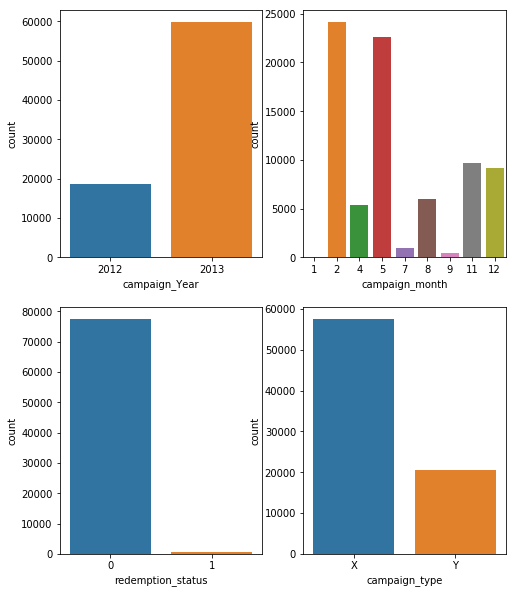

In [288]:
fig,ax=plt.subplots(2,2,figsize=(8,10))
sns.countplot(df_final.campaign_Year,ax=ax[0,0])
sns.countplot(df_final.campaign_month,ax=ax[0,1])
sns.countplot(df_final.redemption_status,ax=ax[1,0])
sns.countplot(df_final.campaign_type,ax=ax[1,1])
plt.show()

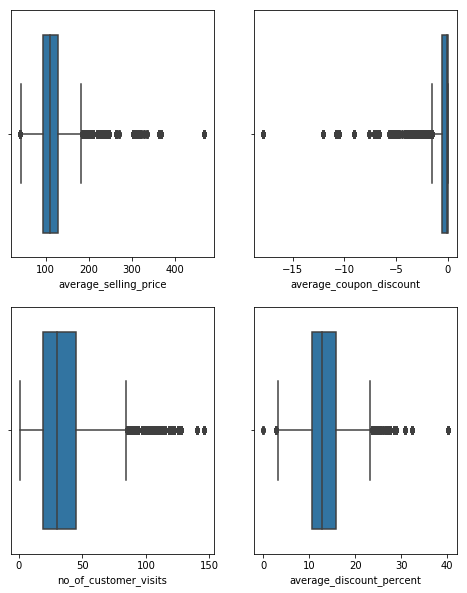

In [292]:
fig,ax=plt.subplots(2,2,figsize=(8,10))
sns.boxplot(df_final.average_selling_price,ax=ax[0,0])
sns.boxplot(df_final.average_coupon_discount,ax=ax[0,1])
sns.boxplot(df_final.no_of_customer_visits,ax=ax[1,0])
sns.boxplot(df_final.average_discount_percent,ax=ax[1,1])
plt.show()

### Bivariate Analysis

In [294]:
df_final.loc[:,"coupon_item_count":"average_other_discount"].cov()

,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount
coupon_item_count,365786.845969,189.599626,-61.729899,1.334663
average_item_quantity_purchased,189.599626,44821.559207,4279.638321,-177.314226
average_selling_price,-61.729899,4279.638321,1203.132919,-93.679643
average_other_discount,1.334663,-177.314226,-93.679643,94.944304


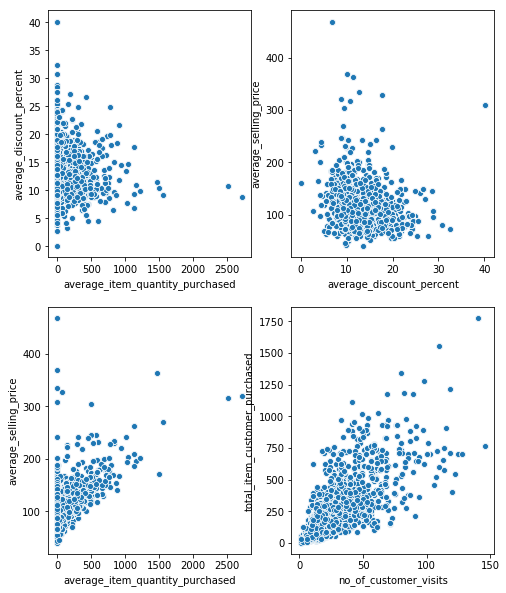

In [296]:
fig,ax=plt.subplots(2,2,figsize=(8,10))
sns.scatterplot(df_final.average_item_quantity_purchased,df_final.average_discount_percent,ax=ax[0,0])
sns.scatterplot(df_final.average_discount_percent,df_final.average_selling_price,ax=ax[0,1])
sns.scatterplot(df_final.average_item_quantity_purchased,df_final.average_selling_price,ax=ax[1,0])
sns.scatterplot(df_final.no_of_customer_visits,df_final.total_item_customer_purchased ,ax=ax[1,1])
plt.show()

In [297]:
pd.crosstab(df_final.redemption_status,df_final.campaign_type)

campaign_type,X,Y
redemption_status,,
0,57048,20592
1,627,90


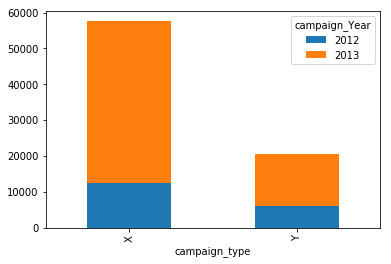

In [298]:
pd.crosstab(df_final.campaign_type,df_final.campaign_Year).plot.bar(stacked=True)
plt.show()

### Multivariate Analysis

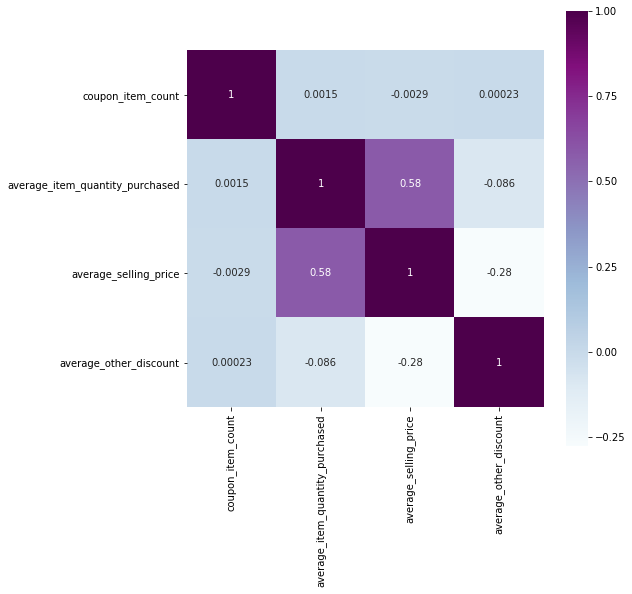

In [303]:
plt.figure(figsize=(8,8))
sns.heatmap(df_final.loc[:,"coupon_item_count":"average_other_discount"].corr(),square=True,cmap="BuPu",annot=True)
plt.show()

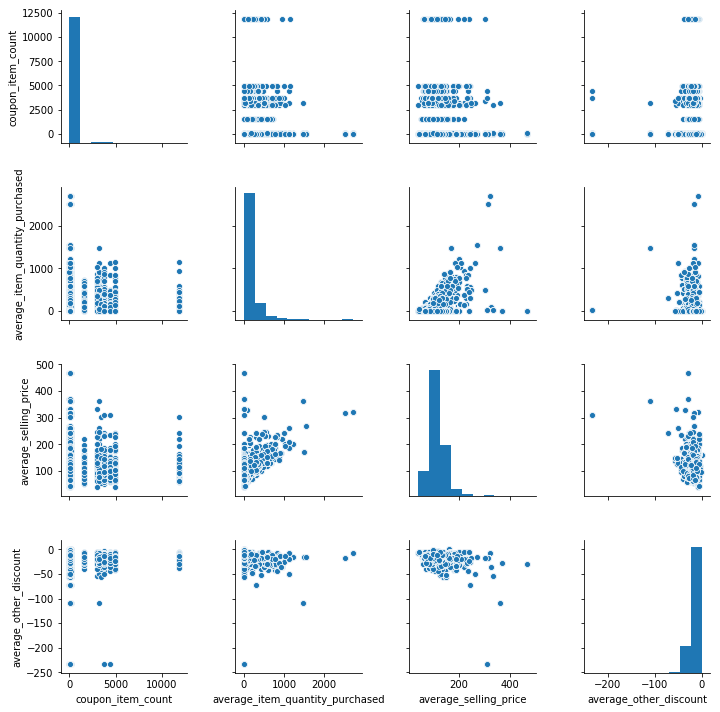

In [301]:
#plt.figure(figsize=(8,8))
sns.pairplot(df_final.loc[:,"coupon_item_count":"average_other_discount"])
plt.show()

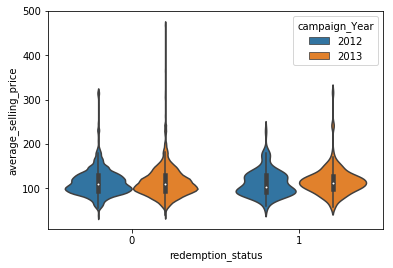

In [302]:
sns.violinplot(df_final.redemption_status,df_final.average_selling_price,hue=df_final.campaign_Year)
plt.show()

In [305]:
df_final.groupby("campaign_Year")[["redemption_status","average_selling_price","average_coupon_discount"]].sum()

,redemption_status,average_selling_price,average_coupon_discount
campaign_Year,,,
2012,116,2126091.579081,-10648.046041
2013,601,6870679.655120,-31829.522561


### Checking null values

In [306]:
df_final.isnull().sum()

id                                                0
campaign_id                                       0
coupon_id                                         0
customer_id                                       0
redemption_status                                 0
campaign_type                                     0
start_date                                        0
end_date                                          0
campaign_period                                   0
campaign_Year                                     0
campaign_month                                    0
campaign_quarter                                  0
campaign_customer_nunique                         0
campaign_coupon_nunique                           0
category_count_Food & Dairy                       0
category_count_Garden                             0
category_count_Grocery                            0
category_count_Health & Personal care             0
category_count_Meat & Fish                        0
category_cou

In [307]:
df_final.nunique()

id                                                78357
campaign_id                                          18
coupon_id                                           866
customer_id                                        1428
redemption_status                                     2
campaign_type                                         2
start_date                                           17
end_date                                             17
campaign_period                                      12
campaign_Year                                         2
campaign_month                                        9
campaign_quarter                                      6
campaign_customer_nunique                            17
campaign_coupon_nunique                              17
category_count_Food & Dairy                          25
category_count_Garden                                 5
category_count_Grocery                               88
category_count_Health & Personal care           

In [308]:
# Droping id columns
df_final.drop(["id","campaign_id","coupon_id","customer_id"],axis=1,inplace=True)

In [309]:
df_final.head(2)

,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
0,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,2,125,460.000000,149.277286,-27.687286,0.000000,10.438539,70,24,0.000000,0.000000,41.000000,6.000000,17.000000,6.000000,0
1,0,X,2013-05-19,2013-05-07,56,2013,5,6,1077,207,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1,3,76.000000,327.843205,-35.644808,-5.137500,17.693347,156,29,4.000000,0.000000,98.000000,30.000000,21.000000,3.000000,6


In [310]:
df_final.shape

(78357, 34)

In [311]:
df_final.describe()

,redemption_status,campaign_period,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
count,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000,78357.000000
mean,0.009150,72.235435,5.319971,714.222711,153.076611,2.278265,1.947369,34.320163,29.389397,13.693352,0.196179,69.907615,11.917110,6.874051,81.824725,118.282170,114.817709,-18.528505,-0.542103,13.379931,330.126307,34.662060,12.965555,0.531886,232.839325,55.569700,23.664140,4.555700,4.849701
std,0.095220,30.014823,1.175377,428.162422,81.439482,20.845629,37.866852,246.582343,478.290913,215.545526,2.625308,532.445055,87.907183,64.703696,604.803146,211.711028,34.686206,9.743937,1.193340,3.968070,238.530767,22.070984,19.030259,1.237576,170.906935,52.382202,20.005253,7.383978,11.277907
min,0.000000,31.000000,3.000000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,39.862979,-232.773772,-17.809848,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,56.000000,5.000000,214.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,5.000000,1.000000,93.640597,-21.325164,-0.598799,10.591091,159.000000,19.000000,3.000000,0.000000,113.000000,20.000000,9.000000,0.000000,0.000000
50%,0.000000,62.000000,5.000000,1076.000000,207.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,12.000000,13.000000,109.394206,-17.263445,-0.128240,12.857054,272.000000,30.000000,7.000000,0.000000,192.000000,39.000000,18.000000,1.000000,1.000000
75%,0.000000,77.000000,6.000000,1077.000000,208.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,27.000000,0.000000,1.000000,30.000000,158.000000,129.391844,-13.709114,0.000000,15.780453,435.000000,45.000000,15.000000,1.000000,316.000000,72.000000,33.000000,6.000000,4.000000
max,1.000000,182.000000,8.000000,1077.000000,208.000000,276.000000,747.000000,4127.000000,11786.000000,4340.000000,50.000000,10744.000000,1171.000000,1187.000000,11813.000000,2713.000000,468.756667,0.000000,0.000000,40.161368,1775.000000,146.000000,227.000000,11.000000,1277.000000,466.000000,128.000000,58.000000,100.000000


In [312]:
df_final.describe(include="object")

,campaign_type,campaign_Year,campaign_month
count,78357,78357,78357
unique,2,2,9
top,X,2013,2
freq,57675,59821,24136


In [313]:
df_final.corr()

,redemption_status,campaign_period,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
redemption_status,1.000000,-0.018691,0.012382,0.034098,0.031918,0.031155,0.002990,0.075881,0.013219,0.032297,0.015486,0.050255,0.068711,0.041253,0.054230,0.018800,0.003318,-0.015716,-0.062058,0.039494,0.038440,0.007083,0.018042,0.015123,0.038844,0.031857,0.016145,0.023916,0.106682
campaign_period,-0.018691,1.000000,-0.579251,-0.167344,-0.004124,-0.038222,-0.009195,-0.033306,-0.020158,-0.013042,-0.016622,-0.034104,-0.042039,-0.023573,-0.036134,0.016917,0.009024,0.002488,-0.003228,-0.011760,0.016677,0.034176,0.033768,-0.010337,0.013580,0.014534,0.008888,0.011929,-0.010765
campaign_quarter,0.012382,-0.579251,1.000000,0.134239,-0.181137,0.044844,0.006874,0.023860,0.030988,0.010263,0.015495,0.038896,0.039163,0.021807,0.039935,0.015649,0.023940,0.015829,-0.003793,-0.022930,-0.053693,-0.072290,-0.066036,-0.020552,-0.056327,-0.014303,-0.059996,0.006868,-0.005910
campaign_customer_nunique,0.034098,-0.167344,0.134239,1.000000,0.859626,0.047692,0.043272,0.062281,0.035677,0.051861,0.056866,0.071802,0.092727,0.074995,0.076689,-0.014634,-0.026657,0.000808,0.016042,0.008730,-0.148102,-0.092386,-0.091609,-0.060078,-0.139814,-0.140567,-0.092836,-0.053302,-0.071604
campaign_coupon_nunique,0.031918,-0.004124,-0.181137,0.859626,1.000000,0.028511,0.034334,0.046541,0.024936,0.040935,0.043324,0.051880,0.075205,0.059208,0.056604,-0.015042,-0.030948,-0.024762,0.003662,0.037665,-0.101856,-0.023839,-0.074086,-0.048487,-0.091699,-0.116812,-0.037637,-0.038192,-0.046972
category_count_Food & Dairy,0.031155,-0.038222,0.044844,0.047692,0.028511,1.000000,0.641999,0.571235,0.140721,0.088873,0.615245,0.435881,0.477857,0.314294,0.453188,-0.000437,-0.001681,-0.000304,-0.003837,-0.000267,-0.013040,-0.011042,-0.001503,-0.006864,-0.011973,-0.015040,-0.009212,-0.007421,-0.000204
category_count_Garden,0.002990,-0.009195,0.006874,0.043272,0.034334,0.641999,1.000000,-0.002526,0.218229,-0.001850,0.941225,0.277654,0.105116,0.292779,0.259714,0.000603,0.002664,0.001024,-0.003672,-0.001916,-0.007116,-0.006233,-0.004818,-0.004845,-0.006175,-0.009378,-0.001205,-0.003920,0.001100
category_count_Grocery,0.075881,-0.033306,0.023860,0.062281,0.046541,0.571235,-0.002526,1.000000,-0.005236,0.092779,0.024259,0.386328,0.799178,0.182628,0.456268,0.001120,-0.005804,-0.002860,-0.001574,0.005628,-0.009339,-0.008753,-0.000286,-0.005767,-0.008388,-0.011185,-0.007671,-0.005712,-0.000975
category_count_Health & Personal care,0.013219,-0.020158,0.030988,0.035677,0.024936,0.140721,0.218229,-0.005236,1.000000,-0.001977,0.278256,0.837016,0.487289,0.371300,0.807703,0.000694,0.000735,0.003226,-0.002136,-0.001679,0.000603,-0.000761,-0.000456,0.002036,0.000693,-0.000405,0.002095,0.001456,0.005261
category_count_Meat & Fish,0.032297,-0.013042,0.010263,0.051861,0.040935,0.088873,-0.001850,0.092779,-0.001977,1.000000,0.321516,0.399397,0.312230,0.894537,0.396996,0.001258,-0.003570,-0.003401,-0.002342,0.001684,0.000575,0.005682,0.002445,-0.000654,0.000846,-0.002351,0.002070,0.003887,0.000257


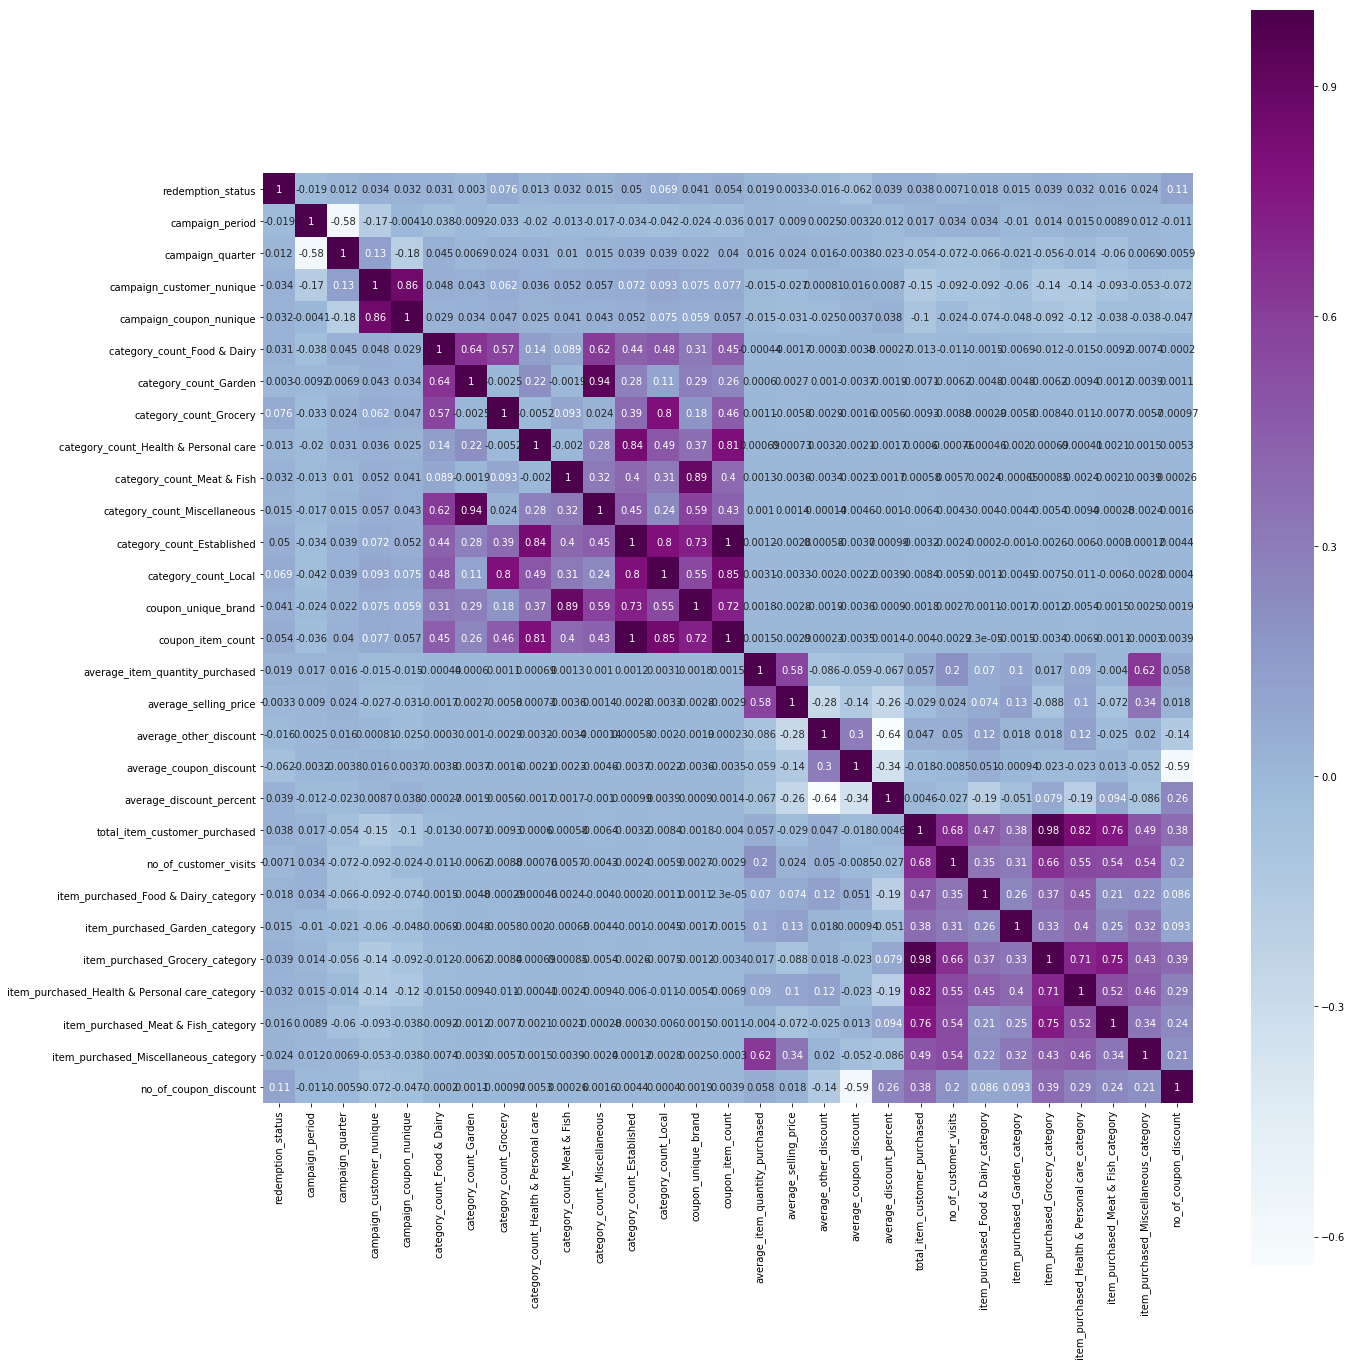

In [314]:
plt.figure(figsize=(20,20))
sns.heatmap(df_final.corr(),square=True,cmap="BuPu",annot=True)
plt.tight_layout()
plt.show()

In [315]:
# Since there is very high correlation between coupon_item count and category_count_Established, we are removing category_count_Established feature

In [316]:
df_final.drop("category_count_Established",axis=1,inplace=True)

### Encoding

In [317]:
# Dropping start_date and end_date
df_final.drop(["start_date","end_date"],axis=1,inplace=True)

In [318]:
df_final=pd.get_dummies(df_final,columns=["campaign_type","campaign_Year","campaign_month"],drop_first=True)
df_final.head()

,redemption_status,campaign_period,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount,campaign_type_Y,campaign_Year_2013,campaign_month_2,campaign_month_4,campaign_month_5,campaign_month_7,campaign_month_8,campaign_month_9,campaign_month_11,campaign_month_12
0,0,56,6,1077,207,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,0.000000,2,125,460.000000,149.277286,-27.687286,0.000000,10.438539,70,24,0.000000,0.000000,41.000000,6.000000,17.000000,6.000000,0,0,1,0,0,1,0,0,0,0,0
1,0,56,6,1077,207,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,1,3,76.000000,327.843205,-35.644808,-5.137500,17.693347,156,29,4.000000,0.000000,98.000000,30.000000,21.000000,3.000000,6,0,1,0,0,1,0,0,0,0,0
2,0,31,8,176,18,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,0.000000,1,67,2.000000,117.771477,-18.151711,-2.736040,12.490265,298,26,7.000000,0.000000,207.000000,45.000000,38.000000,1.000000,29,1,1,0,0,0,0,0,0,1,0
3,0,56,6,1077,207,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1,4,1.000000,87.685000,-8.998026,0.000000,9.597842,76,23,1.000000,0.000000,63.000000,11.000000,0.000000,1.000000,0,0,1,0,0,1,0,0,0,0,0
4,0,77,5,1076,208,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1,32,137.000000,128.862871,-28.806832,-0.193960,17.530689,101,18,3.000000,0.000000,60.000000,19.000000,15.000000,4.000000,1,0,1,1,0,0,0,0,0,0,0


In [319]:
df_final.shape

(78357, 38)

In [320]:
df_final.columns

Index(['redemption_status', 'campaign_period', 'campaign_quarter',
       'campaign_customer_nunique', 'campaign_coupon_nunique',
       'category_count_Food & Dairy', 'category_count_Garden',
       'category_count_Grocery', 'category_count_Health & Personal care',
       'category_count_Meat & Fish', 'category_count_Miscellaneous',
       'category_count_Local', 'coupon_unique_brand', 'coupon_item_count',
       'average_item_quantity_purchased', 'average_selling_price',
       'average_other_discount', 'average_coupon_discount',
       'average_discount_percent', 'total_item_customer_purchased',
       'no_of_customer_visits', 'item_purchased_Food & Dairy_category',
       'item_purchased_Garden_category', 'item_purchased_Grocery_category',
       'item_purchased_Health & Personal care_category',
       'item_purchased_Meat & Fish_category',
       'item_purchased_Miscellaneous_category', 'no_of_coupon_discount',
       'campaign_type_Y', 'campaign_Year_2013', 'campaign_month_2',
  

### Outlier 

In [322]:
num_list=['campaign_period', 'campaign_quarter',
       'campaign_customer_nunique', 'campaign_coupon_nunique',
       'category_count_Food & Dairy', 'category_count_Garden',
       'category_count_Grocery', 'category_count_Health & Personal care',
       'category_count_Meat & Fish', 'category_count_Miscellaneous',
       'category_count_Local', 'coupon_unique_brand', 'coupon_item_count',
       'average_item_quantity_purchased', 'average_selling_price',
       'average_other_discount', 'average_coupon_discount',
       'average_discount_percent', 'total_item_customer_purchased',
       'no_of_customer_visits', 'item_purchased_Food & Dairy_category',
       'item_purchased_Garden_category', 'item_purchased_Grocery_category',
       'item_purchased_Health & Personal care_category',
       'item_purchased_Meat & Fish_category',
       'item_purchased_Miscellaneous_category', 'no_of_coupon_discount']

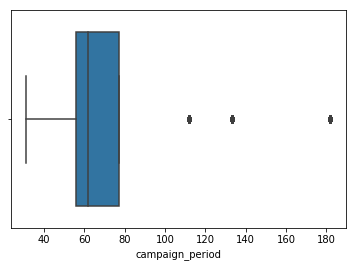

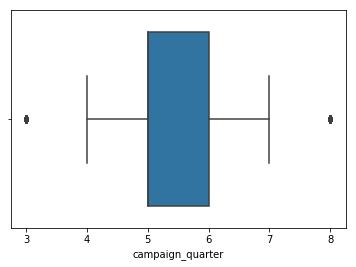

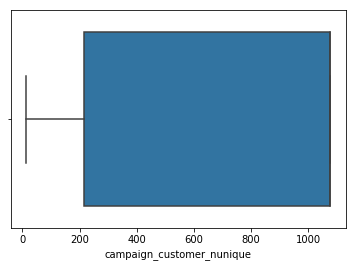

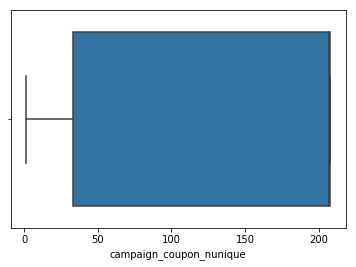

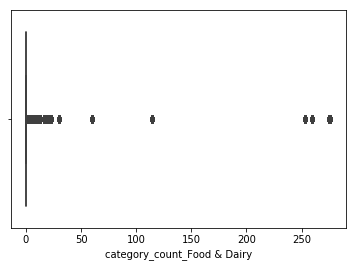

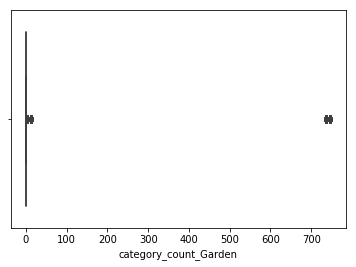

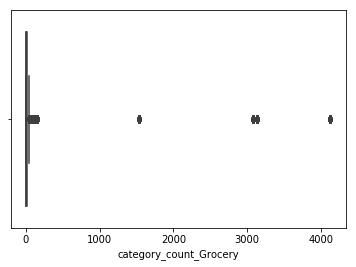

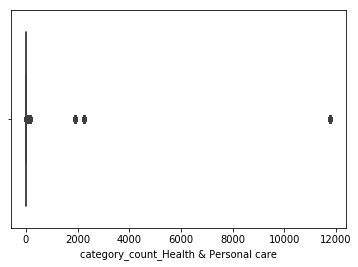

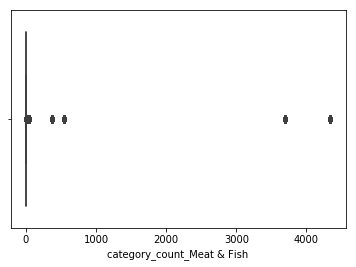

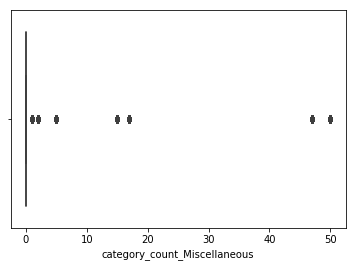

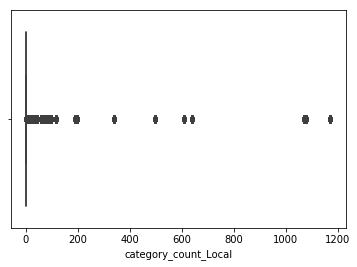

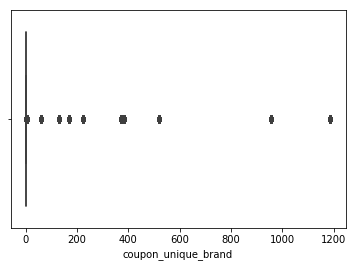

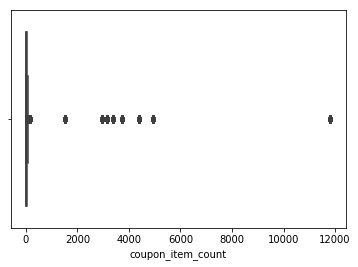

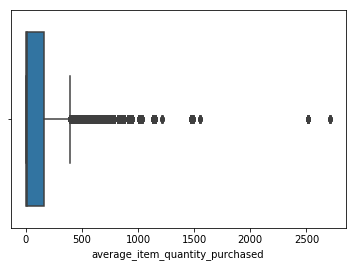

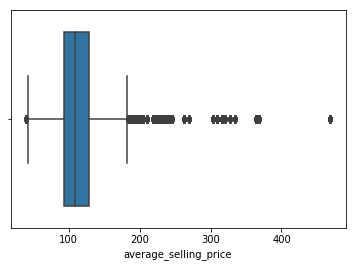

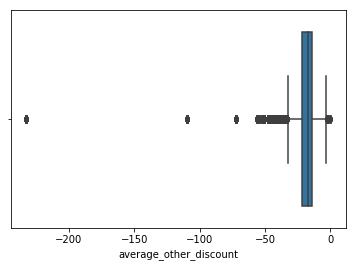

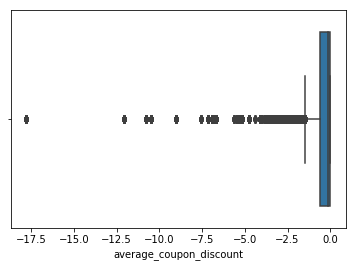

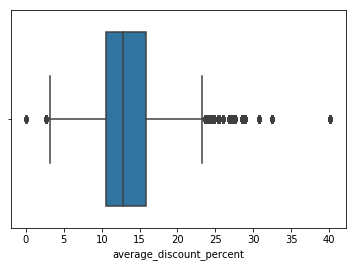

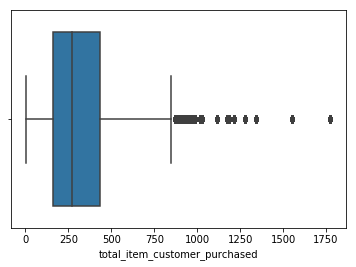

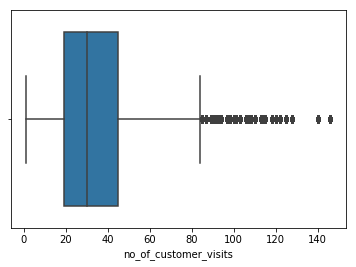

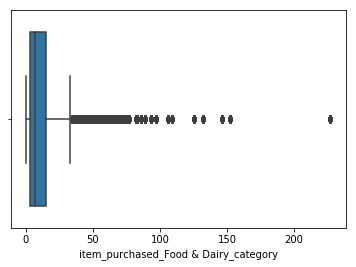

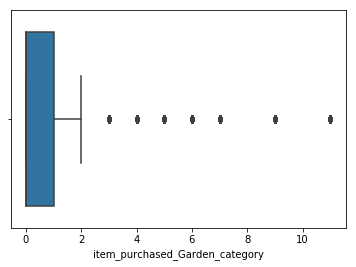

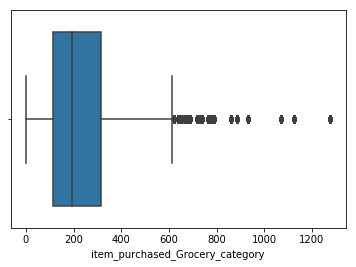

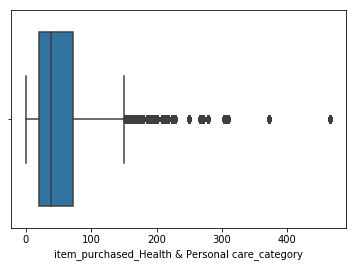

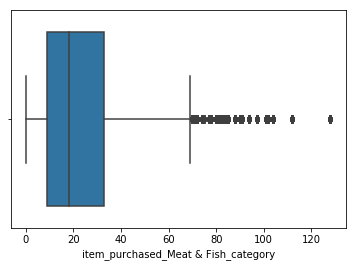

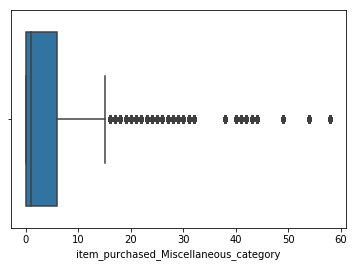

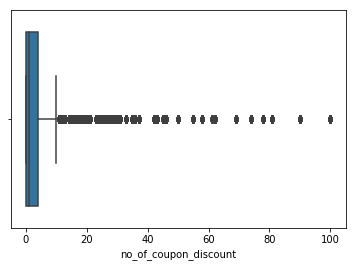

In [323]:
for i in num_list:
    sns.boxplot(df_final[i])
    plt.show()

### Data Distribution

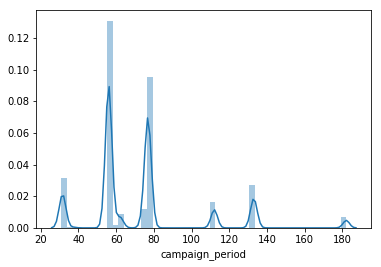

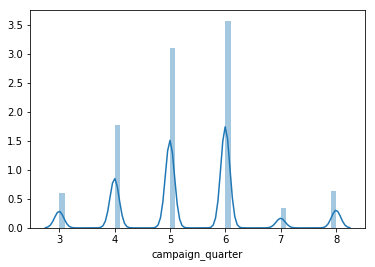

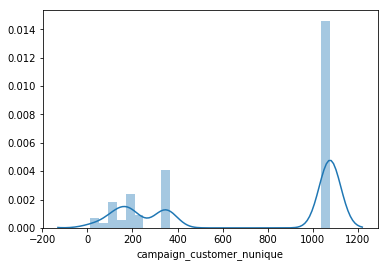

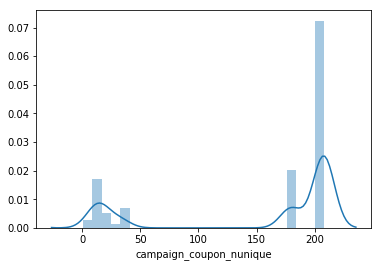

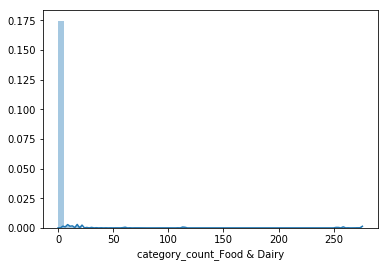

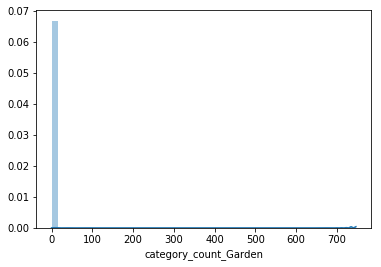

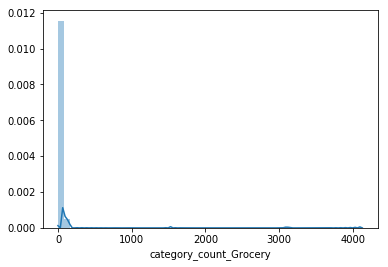

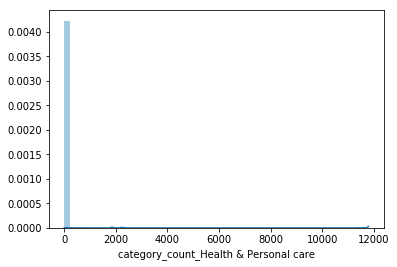

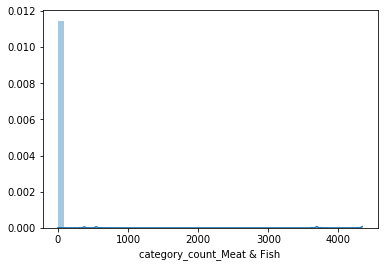

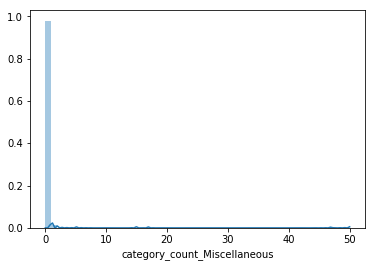

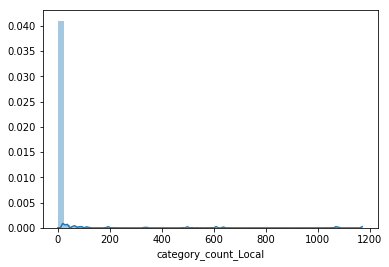

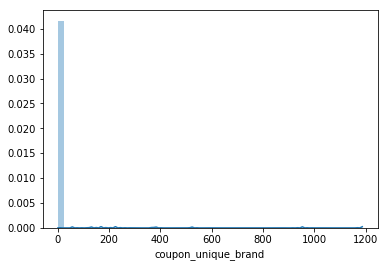

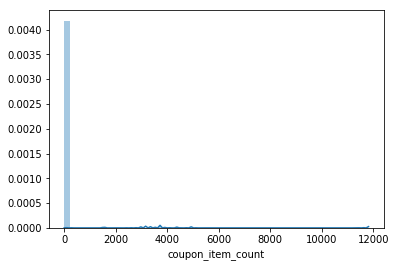

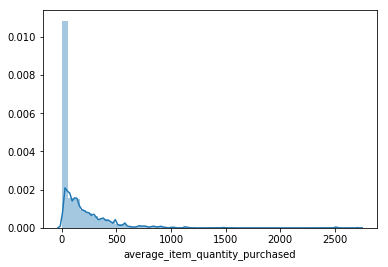

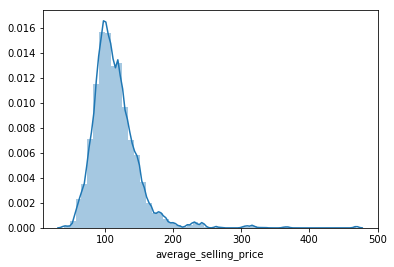

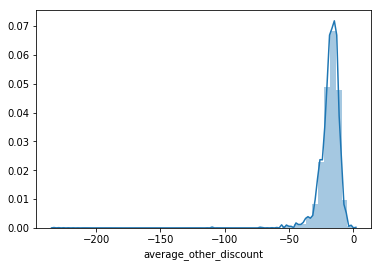

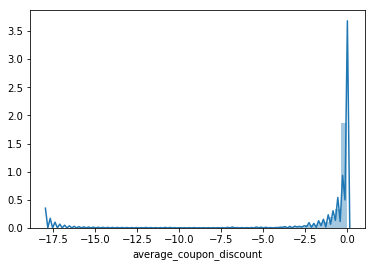

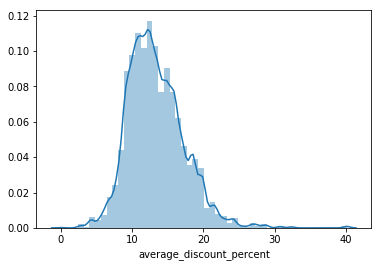

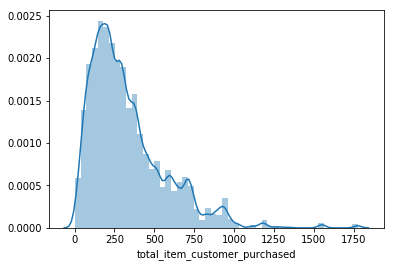

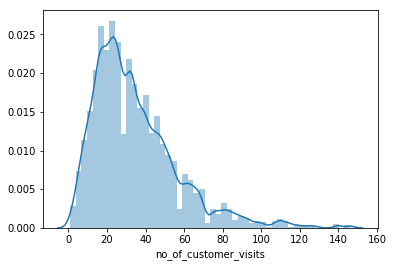

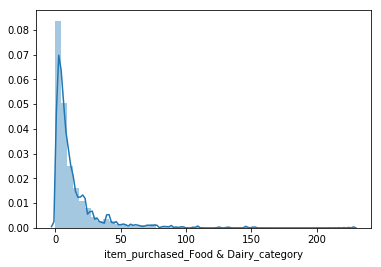

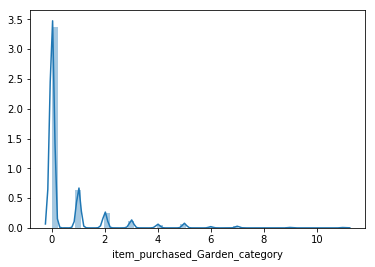

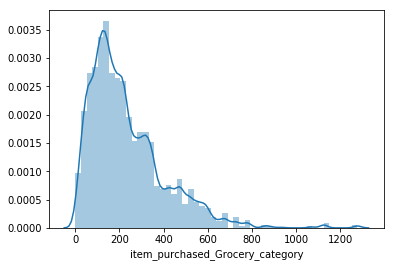

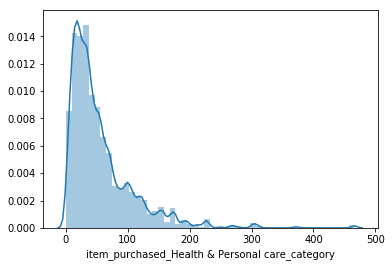

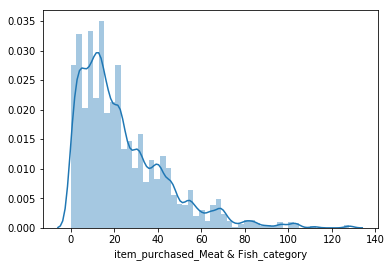

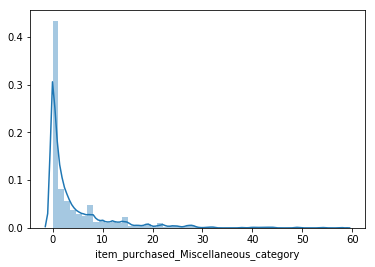

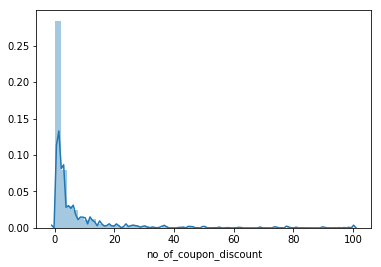

In [324]:
for i in num_list:
    sns.distplot(df_final[i])
    plt.show()

### Checking for Multicollinearity in data

In [327]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
df_num=df_final[num_list]

In [328]:
df_num.head()

,campaign_period,campaign_quarter,campaign_customer_nunique,campaign_coupon_nunique,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Local,coupon_unique_brand,coupon_item_count,average_item_quantity_purchased,average_selling_price,average_other_discount,average_coupon_discount,average_discount_percent,total_item_customer_purchased,no_of_customer_visits,item_purchased_Food & Dairy_category,item_purchased_Garden_category,item_purchased_Grocery_category,item_purchased_Health & Personal care_category,item_purchased_Meat & Fish_category,item_purchased_Miscellaneous_category,no_of_coupon_discount
0,56,6,1077,207,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,0.000000,2,125,460.000000,149.277286,-27.687286,0.000000,10.438539,70,24,0.000000,0.000000,41.000000,6.000000,17.000000,6.000000,0
1,56,6,1077,207,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,1,3,76.000000,327.843205,-35.644808,-5.137500,17.693347,156,29,4.000000,0.000000,98.000000,30.000000,21.000000,3.000000,6
2,31,8,176,18,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,0.000000,1,67,2.000000,117.771477,-18.151711,-2.736040,12.490265,298,26,7.000000,0.000000,207.000000,45.000000,38.000000,1.000000,29
3,56,6,1077,207,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1,4,1.000000,87.685000,-8.998026,0.000000,9.597842,76,23,1.000000,0.000000,63.000000,11.000000,0.000000,1.000000,0
4,77,5,1076,208,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1,32,137.000000,128.862871,-28.806832,-0.193960,17.530689,101,18,3.000000,0.000000,60.000000,19.000000,15.000000,4.000000,1


In [329]:
vif=pd.DataFrame()
vif["VIF"]=[variance_inflation_factor(df_num.values,i) for i in range(df_num.shape[1])]
vif["Features"]=df_num.columns
vif.sort_values("VIF",ascending=False)

C:\Users\hp1\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Features
12,inf,coupon_item_count
9,inf,category_count_Miscellaneous
22,inf,item_purchased_Grocery_category
21,inf,item_purchased_Garden_category
20,inf,item_purchased_Food & Dairy_category
18,inf,total_item_customer_purchased
25,inf,item_purchased_Miscellaneous_category
24,inf,item_purchased_Meat & Fish_category
23,inf,item_purchased_Health & Personal care_category
8,inf,category_count_Meat & Fish


### Base Model

In [330]:
x= df_final.drop("redemption_status",axis=1)
y=df_final["redemption_status"]

In [334]:
rf=RandomForestClassifier(random_state=0)

In [335]:
cv=cross_val_score(rf,x,y,cv=5,scoring="roc_auc")

In [336]:
cv

array([0.86449523, 0.82736137, 0.83913314, 0.83295864, 0.7988531 ])

In [337]:
#roc_auc score
cv.mean()

0.8325602971842828

In [338]:
# Bias error
1-cv.mean()

0.16743970281571718

In [339]:
# Variance error
np.std(cv,ddof=1)

0.023592398495559688

In [340]:
kfold=KFold(n_splits=5,shuffle=True, random_state=0)
cv=cross_val_score(rf,x,y,cv=kfold)

In [341]:
# Accuracy
np.mean(cv)

0.9891139254793458

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score

In [343]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=0)

In [344]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(random_state=0)

In [345]:
ypred_test=rf.predict(xtest)

In [346]:
confusion_matrix(ytest,ypred_test)

array([[23248,    45],
       [  196,    19]], dtype=int64)

In [347]:
accuracy_score(ytest,ypred_test)

0.9897481708354603

In [348]:
pd.DataFrame(ypred_test)[0].value_counts()

0    23444
1       64
Name: 0, dtype: int64

In [349]:
print(classification_report(ytest,ypred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23293
           1       0.30      0.09      0.14       215

    accuracy                           0.99     23508
   macro avg       0.64      0.54      0.57     23508
weighted avg       0.99      0.99      0.99     23508



In [350]:
# Feature Importance
rf_fit=rf.fit(x,y)

In [351]:
feature_importance=pd.DataFrame(rf.feature_importances_,index=x.columns).reset_index()

In [352]:
feature_importance.columns=["Feature","Score"]

In [365]:
feature_importance=feature_importance.sort_values("Score",ascending=False).reset_index(drop=True)

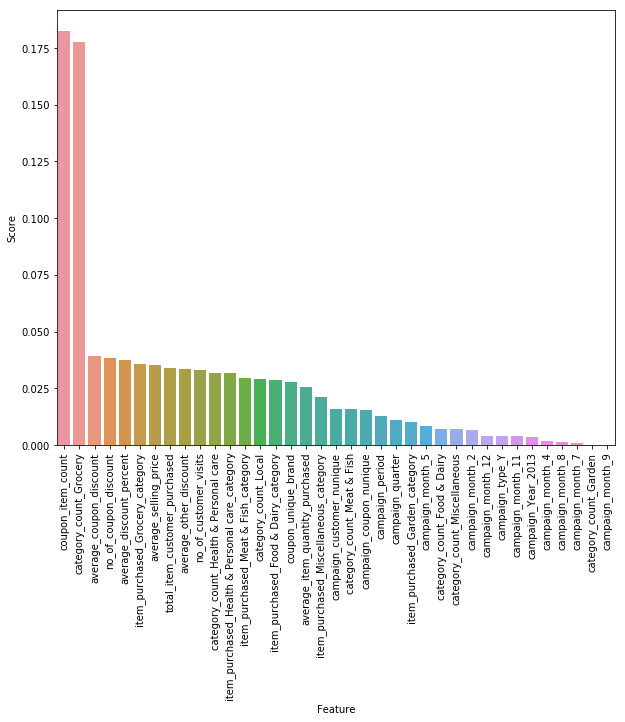

In [366]:
plt.figure(figsize=(10,8))
sns.barplot(feature_importance.Feature,feature_importance.Score)
plt.xticks(rotation=90)
plt.show()

# Imbalanced classification 
-- In order to deal with the imbalanced class problem, the SMOTE ( Synthetic Minority Oversampling Technique) resampling method was implemented.

In [355]:
#pip install imbalanced-learn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [356]:
print("Original data distribution: \n")
print(y.value_counts())

Original data distribution: 

0    77640
1      717
Name: redemption_status, dtype: int64


In [357]:
smote_ratio=0.20
smote=SMOTE(sampling_strategy=smote_ratio)
x_resampled,y_resampled=smote.fit_sample(x,y)

In [358]:
print("New class distribution: \n")
print(y_resampled.value_counts())

New class distribution: 

0    77640
1    15528
Name: redemption_status, dtype: int64


In [359]:
x_resampled.shape

(93168, 37)

In [360]:
y_resampled.shape

(93168,)

### Rebuilding model after resampling using SMOTE technique

In [361]:
rf=RandomForestClassifier()

In [362]:
cv=cross_val_score(rf,x_resampled,y_resampled,cv=5,scoring='roc_auc')

In [363]:
#Accuracy of the Model
np.mean(cv)

0.9970081582502429